# Imports

In [2]:
import proplot as pplt
import matplotlib as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
from rasterio.plot import show
import cartopy.crs as ccrs
from scipy.optimize import curve_fit
from scipy.stats import norm, expon, lognorm
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature

from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.transform import array_bounds

# Figure 1 - Conceptual and Methods

## Load Data

In [26]:
model = pd.read_csv('./Data/point_model_data.csv')
obs = pd.read_csv('./Data/point_data.csv')

## Prepare Data

In [29]:
obs['date'] = pd.to_datetime(obs['date'])
obs['doy'] = obs['date'].dt.day_of_year
obs['year'] = obs['date'].dt.year
obs = obs[obs['EVI_scaled'] != -9999].reset_index(drop=True)

In [30]:
slope = model['slope'].iloc[0]
offset = model['offset'].iloc[0]

In [31]:
ideal_xs = np.linspace(150, 250, 100)
ideal_model_ys =  np.linspace(1, 0.8, 100)
ideal_defol_ys_1 = ideal_model_ys -  0.65*np.exp(-0.005*(ideal_xs - 190)**2) - 0.03
ideal_defol_ys_2 = ideal_model_ys -  0.1*np.exp(-0.001*(ideal_xs - 190)**2)- 0.05

## Make Figure

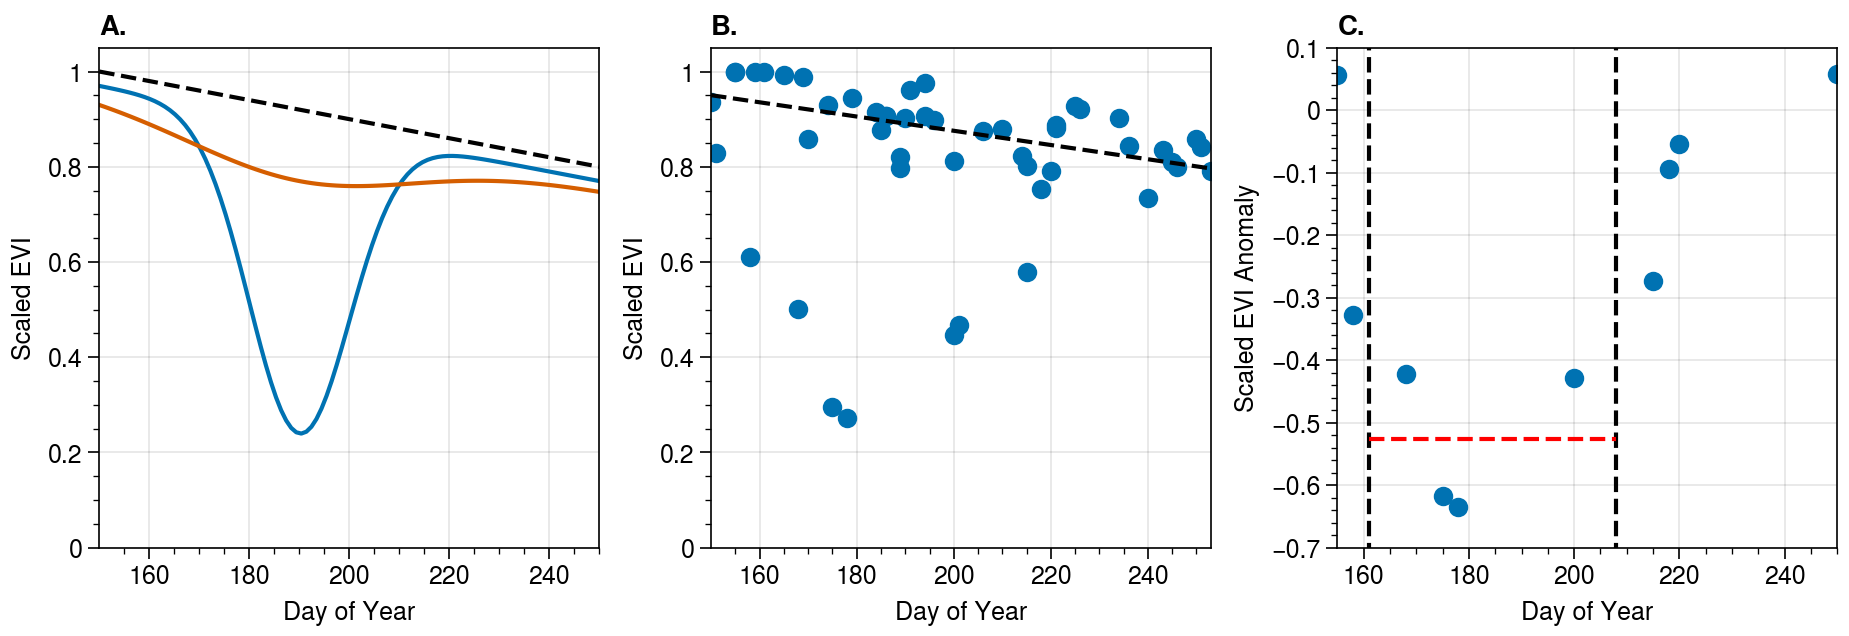

In [33]:
fig, axes = pplt.subplots(nrows=1, ncols=3, share=False, facecolor='none')

axes.format(abc='A.', abcloc='l', abcbbox=True)

axes[0].plot(ideal_xs, ideal_defol_ys_1)
axes[0].plot(ideal_xs, ideal_defol_ys_2)
axes[0].plot(ideal_xs, ideal_model_ys, linestyle='dashed', color='black')
axes[0].format(ylim=[0,1.05], ylabel='Scaled EVI', xlabel='Day of Year')

xs = [obs['doy'].min(), obs['doy'].max()]
ys = [slope*xs[0] + offset, 
      slope*xs[1] + offset]

axes[1].plot(obs['doy'], obs['EVI_scaled'], 'o')
axes[1].plot(xs, ys, color='black', linestyle='dashed')
axes[1].format(ylim=[0,1.05], ylabel='Scaled EVI', xlabel='Day of Year')

obs_2021 = obs[obs['year'] == 2021].reset_index(drop=True)
obs_2021['EVI_scaled_pred'] = slope*obs_2021['doy'] + offset
obs_2021['EVI_scaled_anom'] = obs_2021['EVI_scaled'] - obs_2021['EVI_scaled_pred']
mean = obs_2021.loc[(obs_2021['doy'] >= 161) & (obs_2021['doy'] <= 208), 'EVI_scaled_anom'].mean()

axes[2].plot(obs_2021['doy'], obs_2021['EVI_scaled_anom'], 'o')
axes[2].vlines([161, 208], [-1, -1], [1, 1], linestyle='dashed')
axes[2].plot([161, 208], [mean, mean], linestyle='dashed', color='red')
axes[2].format(ylim=[-0.7, 0.1], ylabel='Scaled EVI Anomaly', xlabel='Day of Year')

fig.savefig('./Figures/Ideal_Trend_Example.png')

# Figure 2 - Site Validation

## Load Data

In [3]:
mt_pleasant_vector = gpd.read_file('./Data/site_validation/mt_pleasant_vector.shp')
mt_pleasant_mean_obs = pd.read_csv('./Data/site_validation/mt_pleasant_mean_obs.csv')
mt_pleasant_median = rio.open('./Data/site_validation/mt_pleasant_median.tif', 'r')
mt_pleasant_defol = rio.open('./Data/site_validation/mt_pleasant_defol.tif', 'r')
mt_pleasant_normal = rio.open('./Data/site_validation/mt_pleasant_normal.tif', 'r')

positive_vector = gpd.read_file('./Data/site_validation/positive_vector.shp')
positive_mean_obs = pd.read_csv('./Data/site_validation/positive_mean_obs.csv')
positive_median = rio.open('./Data/site_validation/positive_median.tif', 'r')
positive_defol = rio.open('./Data/site_validation/positive_defol.tif', 'r')
positive_normal = rio.open('./Data/site_validation/positive_normal.tif', 'r')
positive_aerial = gpd.read_file('./Data/SpongyMoth.gdb')

negative_vector = gpd.read_file('./Data/site_validation/negative_vector.shp')
negative_mean_obs = pd.read_csv('./Data/site_validation/negative_mean_obs.csv')
negative_median = rio.open('./Data/site_validation/negative_median.tif', 'r')
negative_defol = rio.open('./Data/site_validation/negative_defol.tif', 'r')
negative_normal = rio.open('./Data/site_validation/negative_normal.tif', 'r')
negative_aerial = gpd.read_file('./Data/SpongyMoth.gdb')

## Prepare Data

In [4]:
mt_pleasant_median_data = mt_pleasant_median.read()
mt_pleasant_median_data = mt_pleasant_median_data.transpose([1, 2, 0])

mt_pleasant_defol_data = mt_pleasant_defol.read()
mt_pleasant_defol_highlight = (mt_pleasant_defol_data < -0.2).astype(int)
mt_pleasant_defol_highlight = np.ma.masked_where(mt_pleasant_defol_highlight == 0, mt_pleasant_defol_highlight)

mt_pleasant_normal_data = mt_pleasant_normal.read()
mt_pleasant_normal_data = mt_pleasant_normal_data.transpose([1, 2, 0])

mt_pleasant_mean_obs['date'] = pd.to_datetime(mt_pleasant_mean_obs['date'])
mt_pleasant_mean_obs['doy'] = mt_pleasant_mean_obs['date'].dt.day_of_year
mt_pleasant_mean_obs = mt_pleasant_mean_obs.dropna().reset_index()

In [5]:
positive_median_data = positive_median.read()
positive_median_data = positive_median_data.transpose([1, 2, 0])

positive_defol_data = positive_defol.read()
positive_defol_highlight = (positive_defol_data < -0.2).astype(int)
positive_defol_highlight = np.ma.masked_where(positive_defol_highlight == 0, positive_defol_highlight)

positive_normal_data = positive_normal.read()
positive_normal_data = positive_normal_data.transpose([1, 2, 0])

positive_mean_obs['date'] = pd.to_datetime(positive_mean_obs['date'])
positive_mean_obs['doy'] = positive_mean_obs['date'].dt.day_of_year
positive_mean_obs = positive_mean_obs.dropna().reset_index()

positive_aerial = positive_aerial[positive_aerial['GlobalID'] == '{E6D64476-3ECA-485D-B7BB-FB9C234F4A0D}'].unary_union

In [6]:
negative_median_data = negative_median.read()
negative_median_data = negative_median_data.transpose([1, 2, 0])

negative_defol_data = negative_defol.read()
negative_defol_highlight = (negative_defol_data < -0.2).astype(int)
negative_defol_highlight = np.ma.masked_where(negative_defol_highlight == 0, negative_defol_highlight)

negative_normal_data = negative_normal.read()
negative_normal_data = negative_normal_data.transpose([1, 2, 0])

negative_mean_obs['date'] = pd.to_datetime(negative_mean_obs['date'])
negative_mean_obs['doy'] = negative_mean_obs['date'].dt.day_of_year
negative_mean_obs = negative_mean_obs.dropna().reset_index()

negative_aerial = negative_aerial[negative_aerial['GlobalID'] == '{766ED619-AD4B-43E9-81D2-B612736676F9}'].unary_union

## Make Figure

C:\Users\camer\anaconda3\envs\bioee6550\lib\site-packages\cartopy\mpl\geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
C:\Users\camer\anaconda3\envs\bioee6550\lib\site-packages\cartopy\mpl\geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
C:\Users\camer\anaconda3\envs\bioee6550\lib\site-packages\cartopy\mpl\geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
C:\Users\camer\anaconda3\envs\bioee6550\lib\site-packages\cartopy\mpl\geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnin

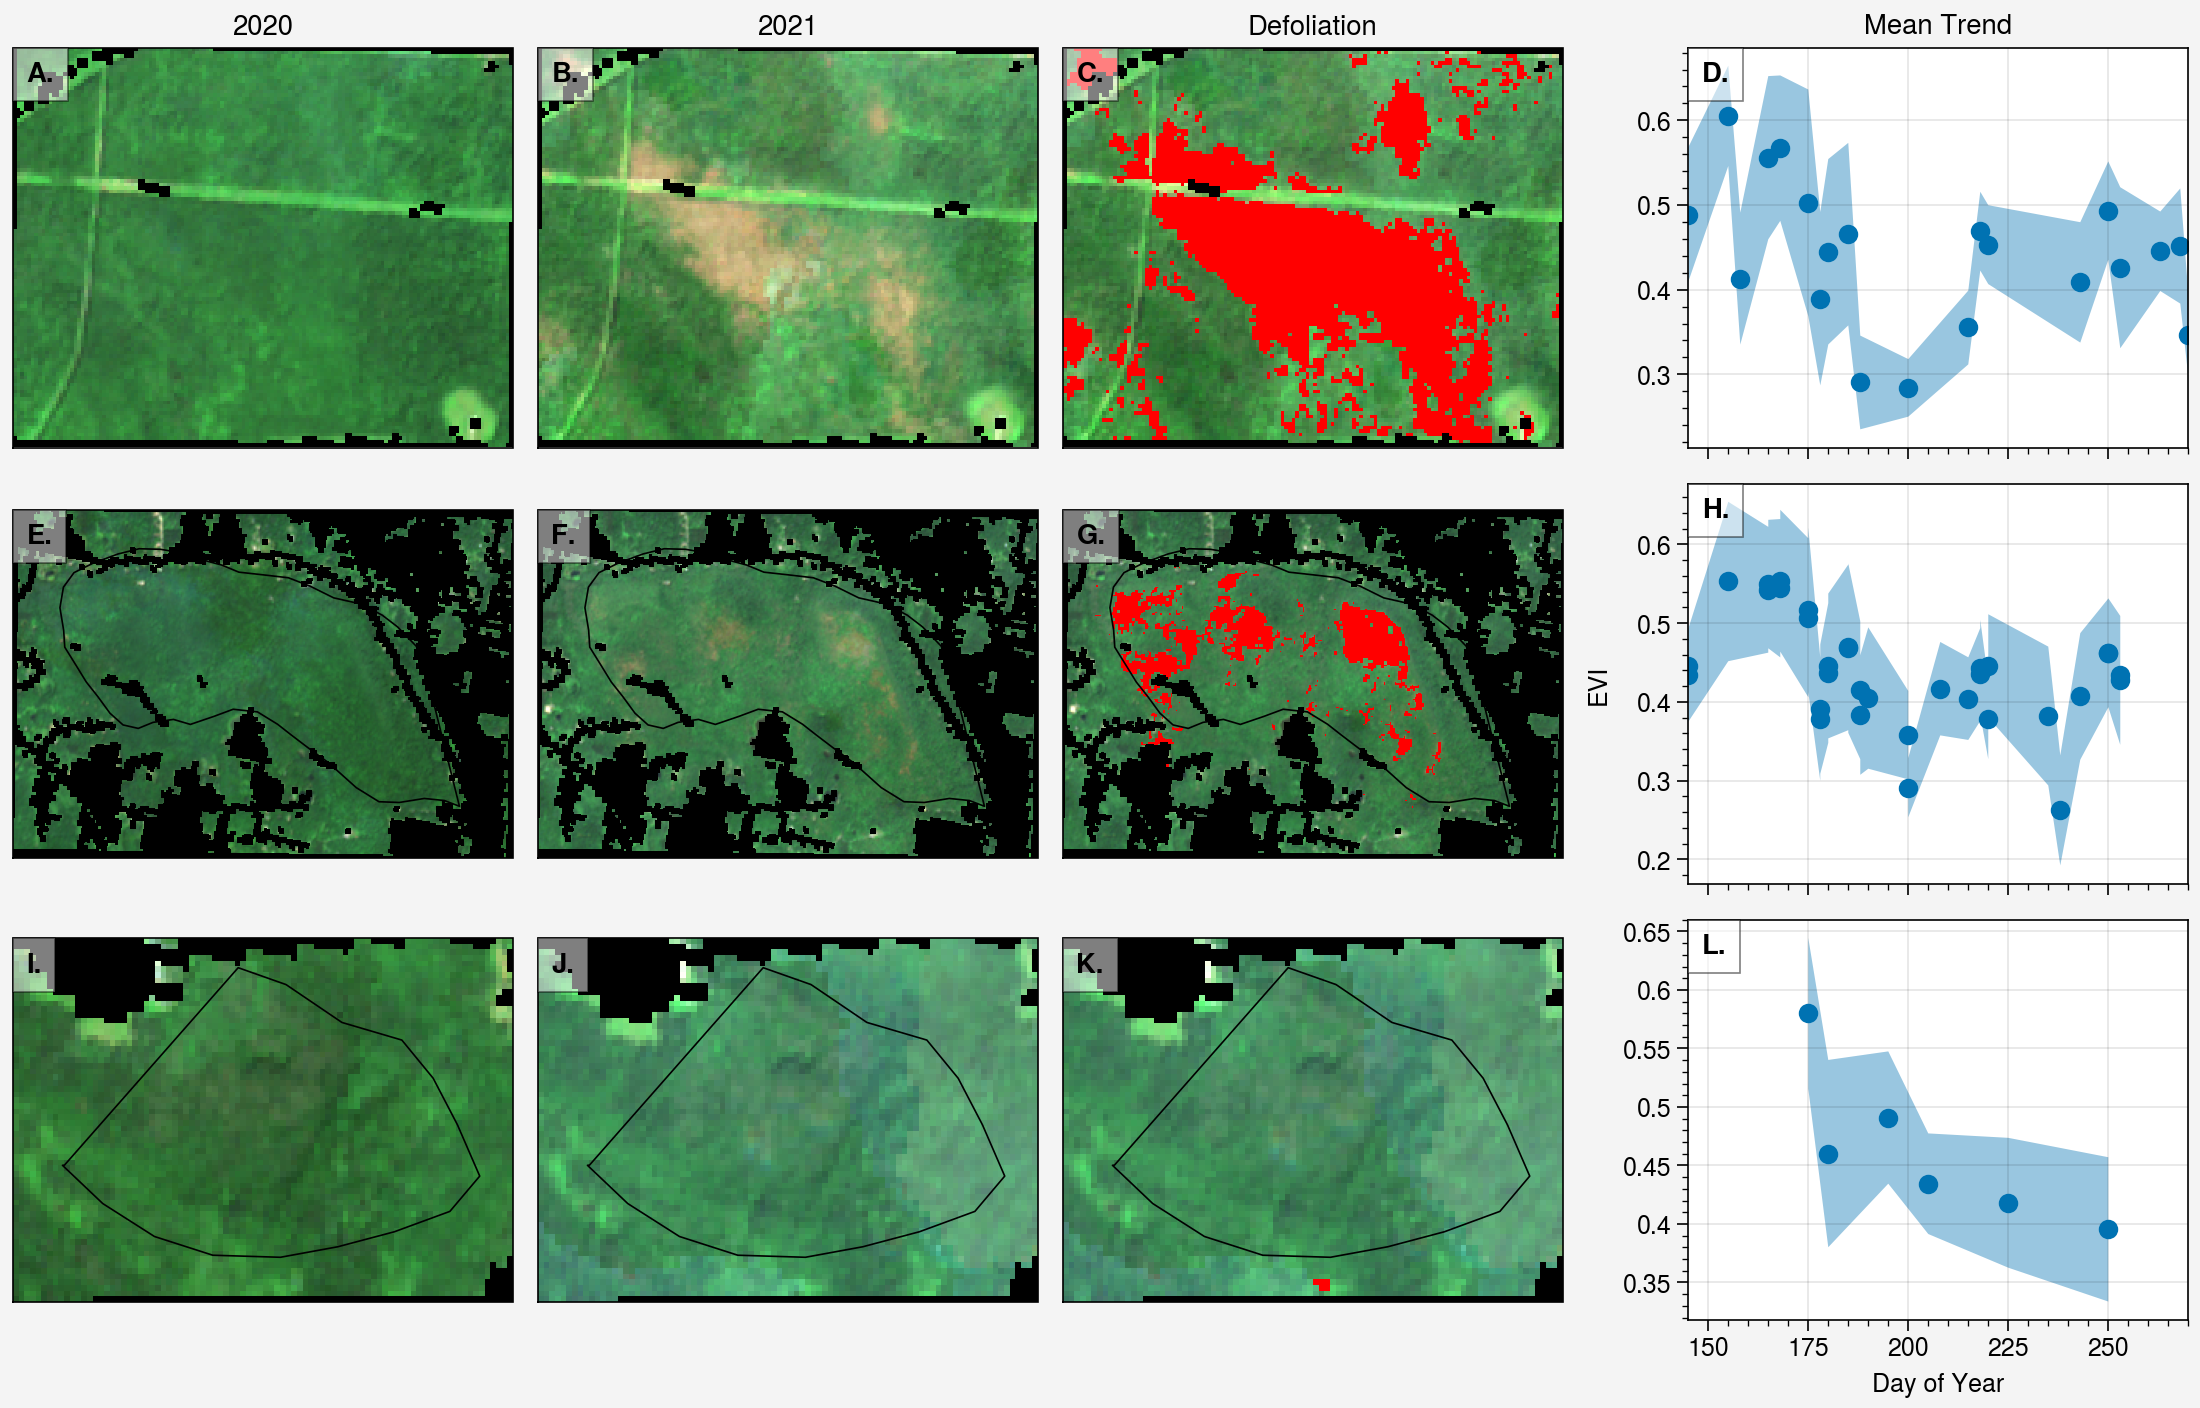

In [8]:
local_proj = ccrs.epsg(32618)
fig, axes = pplt.subplots(nrows=3, ncols=4, proj={(1, 2, 3, 5, 6, 7, 9, 10, 11):local_proj})

axes.format(abc='A.', abcloc='ul', abcbbox=True)

# Mt. Pleasant
## True color normal image
axes[0].imshow(mt_pleasant_normal_data / np.nanmax(mt_pleasant_normal_data), 
               extent=[mt_pleasant_normal.bounds.left, mt_pleasant_normal.bounds.right, mt_pleasant_normal.bounds.bottom, mt_pleasant_normal.bounds.top], 
               origin='upper', transform=local_proj)
axes[0].set_extent([mt_pleasant_normal.bounds.left, mt_pleasant_normal.bounds.right, mt_pleasant_normal.bounds.bottom, mt_pleasant_normal.bounds.top], crs=local_proj)
axes[0].format(title='2020')

## True color defoliation image
axes[1].imshow(mt_pleasant_median_data / np.nanmax(mt_pleasant_normal_data), 
               extent=[mt_pleasant_median.bounds.left, mt_pleasant_median.bounds.right, mt_pleasant_median.bounds.bottom, mt_pleasant_median.bounds.top], 
               origin='upper', transform=local_proj)
axes[1].set_extent([mt_pleasant_median.bounds.left, mt_pleasant_median.bounds.right, mt_pleasant_median.bounds.bottom, mt_pleasant_median.bounds.top], crs=local_proj)
axes[1].format(title='2021')

## True color image with marked defoliation overlayed
axes[2].imshow(mt_pleasant_median_data / np.nanmax(mt_pleasant_normal_data), 
               extent=[mt_pleasant_median.bounds.left, mt_pleasant_median.bounds.right, mt_pleasant_median.bounds.bottom, mt_pleasant_median.bounds.top], 
               origin='upper', transform=local_proj)
axes[2].imshow(mt_pleasant_defol_highlight[0], origin='upper', 
               extent=[mt_pleasant_defol.bounds.left, mt_pleasant_defol.bounds.right, mt_pleasant_defol.bounds.bottom, mt_pleasant_defol.bounds.top], transform=local_proj, color='red')
axes[2].set_extent([mt_pleasant_defol.bounds.left, mt_pleasant_defol.bounds.right, mt_pleasant_defol.bounds.bottom, mt_pleasant_defol.bounds.top], crs=local_proj)
axes[2].format(title='Defoliation')

## Mean observation for defoliated pixels (NEED TO CHANGE GEE SCRIPTS TO DOWNLOAD THIS SPECIFICALLY
axes[3].plot(mt_pleasant_mean_obs['doy'], mt_pleasant_mean_obs['EVI_mean'], 'o', shadedata=mt_pleasant_mean_obs['EVI_std'])
axes[3].format(ylabel='EVI', xlabel='Day of Year')
axes[3].format(title='Mean Trend')


# Positive sample
## True color normal image
axes[4].imshow(positive_normal_data / np.nanmax(positive_normal_data), 
               extent=[positive_normal.bounds.left, positive_normal.bounds.right, positive_normal.bounds.bottom, positive_normal.bounds.top], 
               origin='upper', transform=local_proj)
axes[4].add_geometries([positive_aerial], edgecolor='black', facecolor='none', crs=ccrs.PlateCarree())
axes[4].set_extent([positive_normal.bounds.left, positive_normal.bounds.right, positive_normal.bounds.bottom, positive_normal.bounds.top], crs=local_proj)

## True color defoliation image
axes[5].imshow(positive_median_data / np.nanmax(positive_normal_data), 
               extent=[positive_median.bounds.left, positive_median.bounds.right, positive_median.bounds.bottom, positive_median.bounds.top], 
               origin='upper', transform=local_proj)
axes[5].add_geometries([positive_aerial], edgecolor='black', facecolor='none', crs=ccrs.PlateCarree())
axes[5].set_extent([positive_median.bounds.left, positive_median.bounds.right, positive_median.bounds.bottom, positive_median.bounds.top], crs=local_proj)

## True color image with marked defoliation overlayed
axes[6].imshow(positive_median_data / np.nanmax(positive_normal_data), 
               extent=[positive_median.bounds.left, positive_median.bounds.right, positive_median.bounds.bottom, positive_median.bounds.top], 
               origin='upper', transform=local_proj)
axes[6].imshow(positive_defol_highlight[0], origin='upper', 
               extent=[positive_defol.bounds.left, positive_defol.bounds.right, positive_defol.bounds.bottom, positive_defol.bounds.top], transform=local_proj, color='red')
axes[6].add_geometries([positive_aerial], edgecolor='black', facecolor='none', crs=ccrs.PlateCarree())
axes[6].set_extent([positive_defol.bounds.left, positive_defol.bounds.right, positive_defol.bounds.bottom, positive_defol.bounds.top], crs=local_proj)

## Mean observation for defoliated pixels (NEED TO CHANGE GEE SCRIPTS TO DOWNLOAD THIS SPECIFICALLY
axes[7].plot(positive_mean_obs['doy'], positive_mean_obs['EVI_mean'], 'o', shadedata=positive_mean_obs['EVI_std'])
axes[7].format(ylabel='EVI', xlabel='Day of Year')


# Negative sample
## True color normal image
axes[8].imshow(negative_normal_data / np.nanmax(negative_normal_data), 
               extent=[negative_normal.bounds.left, negative_normal.bounds.right, negative_normal.bounds.bottom, negative_normal.bounds.top], 
               origin='upper', transform=local_proj)
axes[8].add_geometries([negative_aerial], edgecolor='black', facecolor='none', crs=ccrs.PlateCarree())
axes[8].set_extent([negative_normal.bounds.left, negative_normal.bounds.right, negative_normal.bounds.bottom, negative_normal.bounds.top], crs=local_proj)

## True color defoliation image
axes[9].imshow(negative_median_data / np.nanmax(negative_normal_data), 
               extent=[negative_median.bounds.left, negative_median.bounds.right, negative_median.bounds.bottom, negative_median.bounds.top], 
               origin='upper', transform=local_proj)
axes[9].add_geometries([negative_aerial], edgecolor='black', facecolor='none', crs=ccrs.PlateCarree())
axes[9].set_extent([negative_median.bounds.left, negative_median.bounds.right, negative_median.bounds.bottom, negative_median.bounds.top], crs=local_proj)

## True color image with marked defoliation overlayed
axes[10].imshow(negative_median_data / np.nanmax(negative_normal_data), 
               extent=[negative_median.bounds.left, negative_median.bounds.right, negative_median.bounds.bottom, negative_median.bounds.top], 
               origin='upper', transform=local_proj)
axes[10].imshow(negative_defol_highlight[0], origin='upper', 
               extent=[negative_defol.bounds.left, negative_defol.bounds.right, negative_defol.bounds.bottom, negative_defol.bounds.top], transform=local_proj, color='red')
axes[10].add_geometries([negative_aerial], edgecolor='black', facecolor='none', crs=ccrs.PlateCarree())
axes[10].set_extent([negative_defol.bounds.left, negative_defol.bounds.right, negative_defol.bounds.bottom, negative_defol.bounds.top], crs=local_proj)

## Mean observation for defoliated pixels (NEED TO CHANGE GEE SCRIPTS TO DOWNLOAD THIS SPECIFICALLY
axes[11].plot(negative_mean_obs['doy'], negative_mean_obs['EVI_mean'], 'o', shadedata=negative_mean_obs['EVI_std'])
axes[11].format(ylabel='EVI', xlabel='Day of Year')

# TODO: Look into Journal Figure requirements and reformat to better fit
fig.savefig('./Figures/site_validation.png')

# Figure 3 - Aerial Survey Validation

## Load Data

In [12]:
validation = pd.read_csv('./Data/validation.csv')
val_polygons = gpd.read_file('./Data/SpongyMoth.gdb')
new_york_2021 = rio.open('./Data/upscaled_2021.tif', 'r')

In [13]:
validation_light = validation[validation['PCT_AFFECT'] == 'Light (4-10%)']
validation_moderate = validation[validation['PCT_AFFECT'] == 'Moderate (11-29%)']
validation_severe = validation[validation['PCT_AFFECT'] == 'Severe (30-50%)']
validation_very_severe = validation[validation['PCT_AFFECT'] == 'Very Severe (>50%)']

(array([  8.,   2.,   4.,  16.,  36.,  42., 138.,  96.,  82.,  20.]),
 array([-0.29475673, -0.25882972, -0.2229027 , -0.18697568, -0.15104867,
        -0.11512165, -0.07919463, -0.04326762, -0.0073406 ,  0.02858642,
         0.06451344]),
 <a list of 10 Patch objects>)

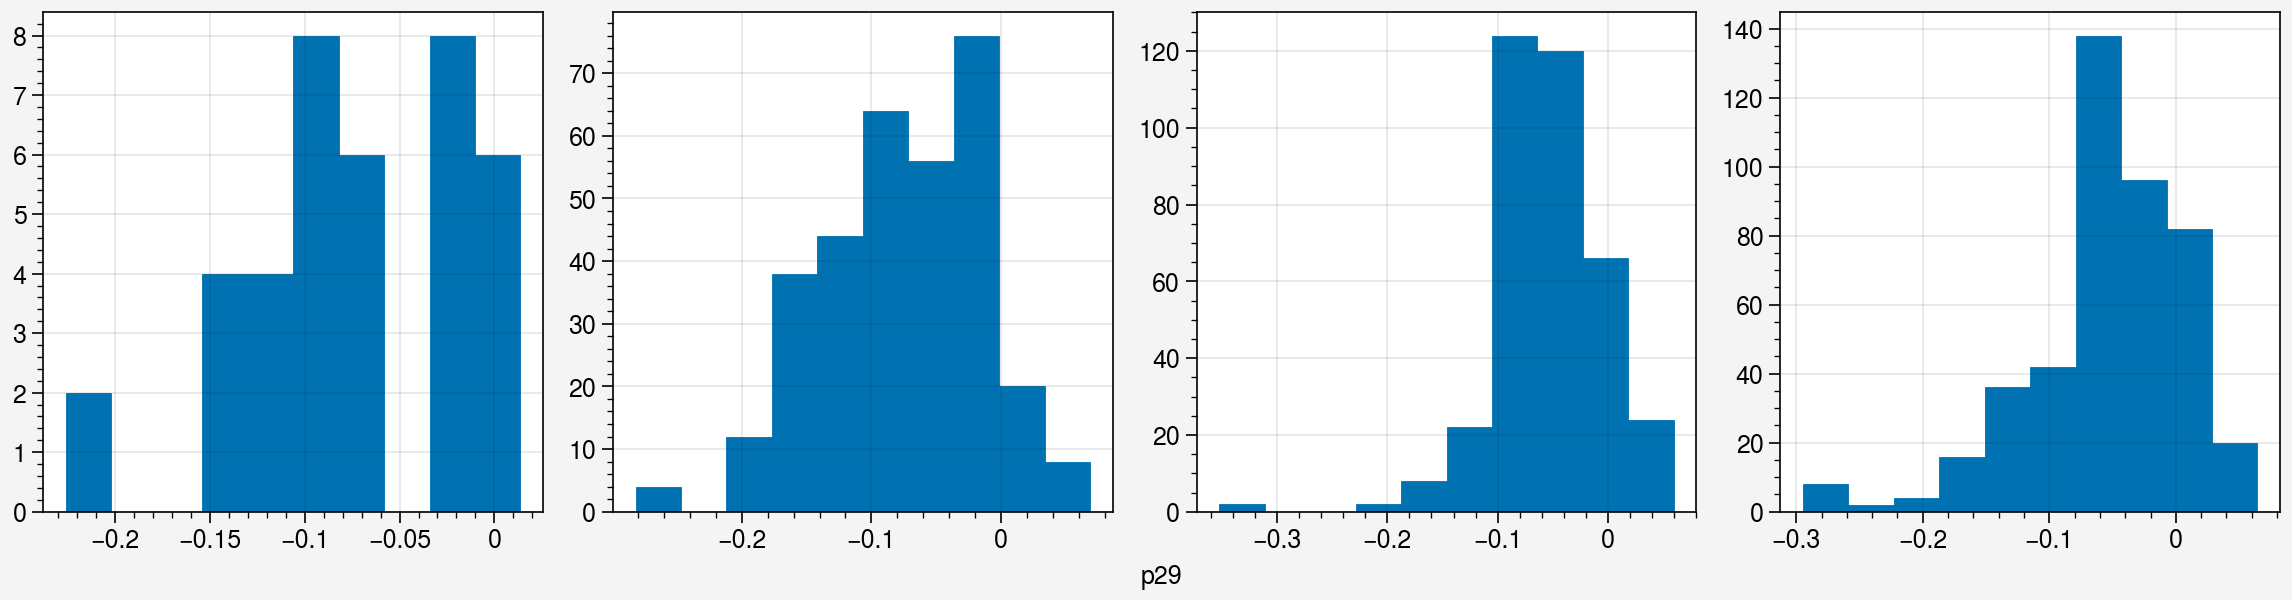

In [14]:
fig, axes = pplt.subplots(nrows=1, ncols=4, sharey=1)

axes[0].hist(validation_light['p10'])

axes[1].hist(validation_moderate['p29'])

axes[2].hist(validation_severe['p50'])

axes[3].hist(validation_very_severe['p50'])

In [15]:
val_polygons_2021 = val_polygons[val_polygons['year'] == 2021]
val_polygons_2021.unary_union
data_2021 = new_york_2021.read()

C:\Users\camer\anaconda3\envs\bioee6550\lib\site-packages\cartopy\mpl\geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
C:\Users\camer\anaconda3\envs\bioee6550\lib\site-packages\cartopy\mpl\geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


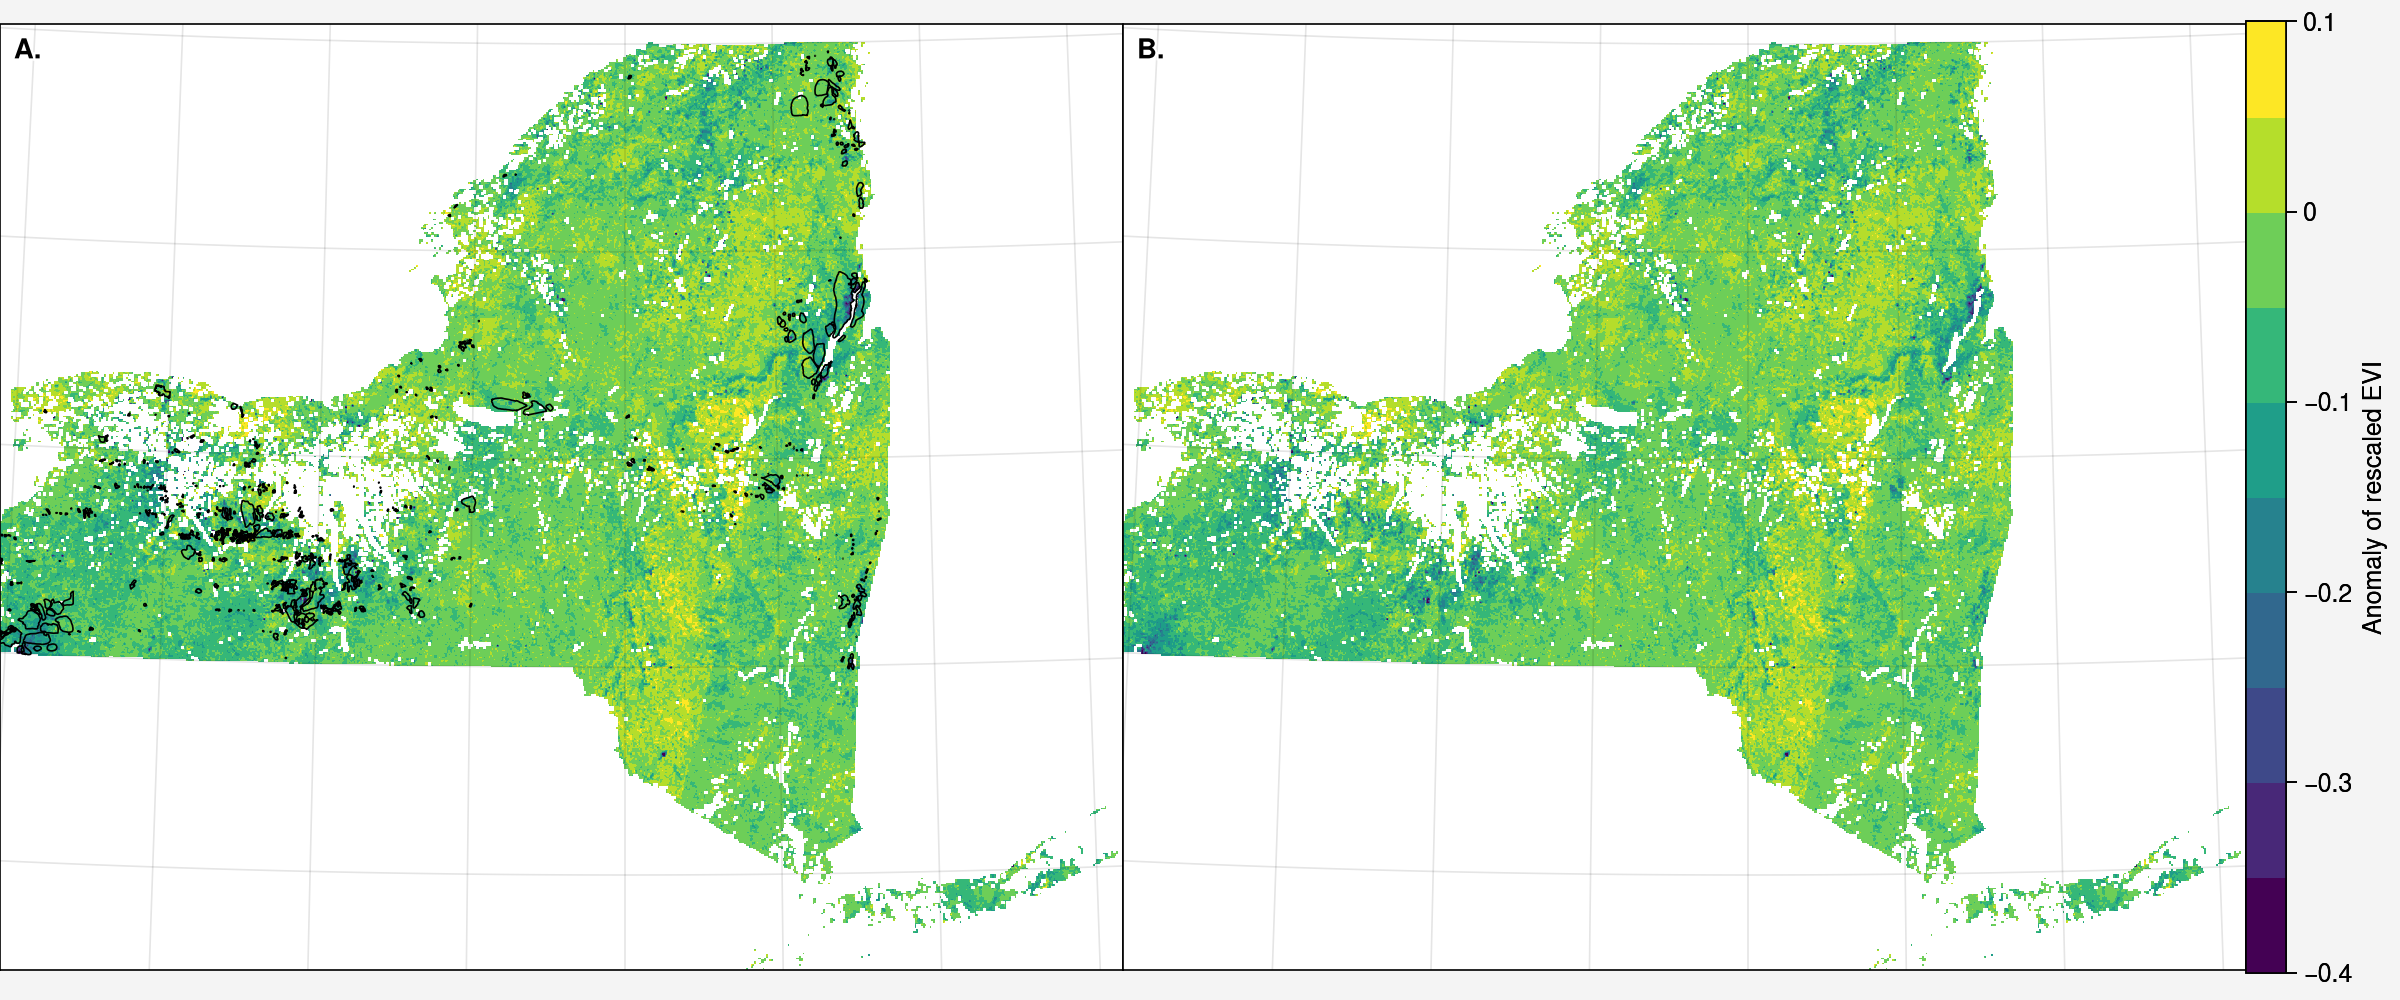

In [43]:
fig, axes = pplt.subplots(nrows=1, ncols=2, figsize=(12,5), proj=ccrs.epsg(32618))

axes.format(abc='A.', abcloc='ul')

vmax = 0.1
vmin = -0.4

axes[0].imshow(data_2021[0], cmap='viridis', levels=np.linspace(vmin, vmax, 11), transform=ccrs.epsg(32618), 
               extent=[new_york_2021.bounds.left, new_york_2021.bounds.right, new_york_2021.bounds.bottom, new_york_2021.bounds.top])
axes[0].set_extent([-79.8, -71.85616396303963, 40.502009391283906, 45.01550900568005], crs=ccrs.PlateCarree())

axes[0].add_geometries(val_polygons_2021.unary_union, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='k')

m = axes[1].imshow(data_2021[0], cmap='viridis', levels=np.linspace(vmin, vmax, 11), transform=ccrs.epsg(32618), 
               extent=[new_york_2021.bounds.left, new_york_2021.bounds.right, new_york_2021.bounds.bottom, new_york_2021.bounds.top])
axes[1].set_extent([-79.8, -71.85616396303963, 40.502009391283906, 45.01550900568005], crs=ccrs.PlateCarree())


fig.colorbar(m, label='Anomaly of rescaled EVI', ticks=0.1, loc='r')

#fig.savefig('./Figures/year_map_upcaled.png')

C:\Users\camer\anaconda3\envs\bioee6550\lib\site-packages\cartopy\mpl\geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


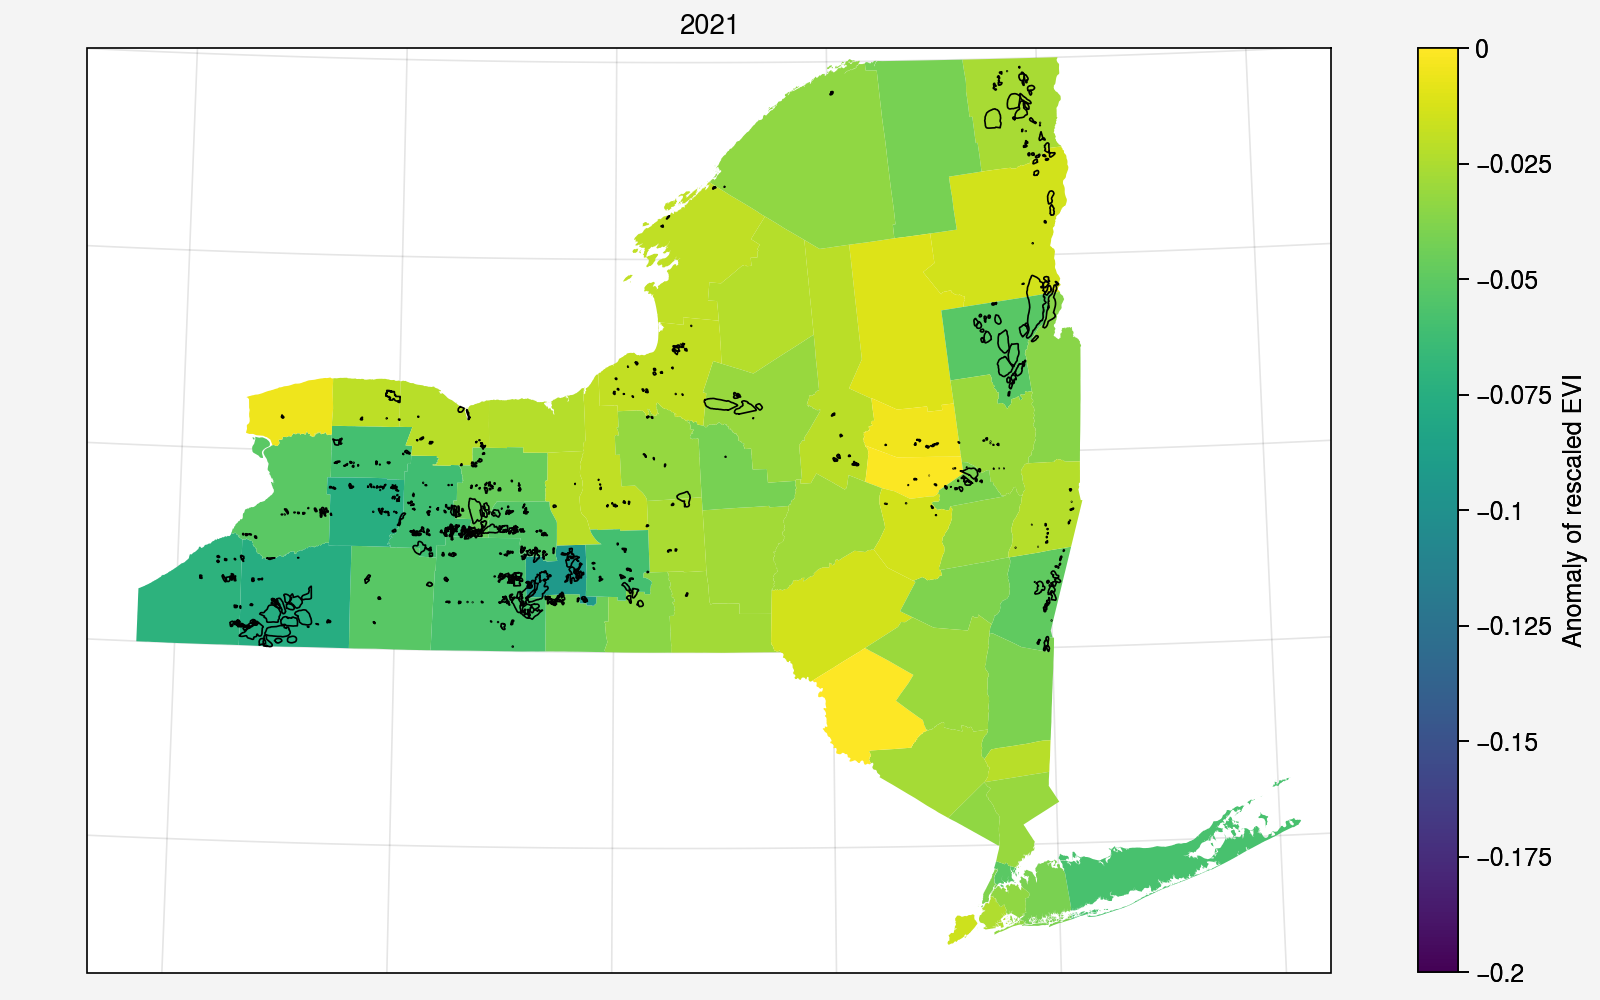

In [53]:
dest_crs = ccrs.LambertConformal(central_longitude=-76.0, central_latitude=42.0,)

fig, ax = pplt.subplots(nrows=1, ncols=1, proj=dest_crs, figsize=(8, 5))

axes.format(abc='A.', abcloc='ul')

norm = plt.colors.Normalize(vmin=-0.2, vmax=0)
cmap = plt.cm.viridis

for row in county_2021.itertuples():
    region = ShapelyFeature(row.geometry,
                            ccrs.PlateCarree(),
                            facecolor=cmap(norm(row.mean))
                           )
    ax.add_feature(region)
ax.set_extent([-80, -71.7, 40.3, 45], crs=ccrs.PlateCarree())

ax.add_geometries(val_polygons_2021.unary_union, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='k')

ax.format(title="2021")

fig.colorbar(cmap, norm=norm, label='Anomaly of rescaled EVI')

fig.savefig('./Figures/county_defol_comparison.png')

# Figure 4 - State-level maps (both down-scaled and county-level)

## Load Data

In [2]:
new_york_2019 = rio.open('./Data/upscaled_2019.tif', 'r')
new_york_2020 = rio.open('./Data/upscaled_2020.tif', 'r')
new_york_2021 = rio.open('./Data/upscaled_2021.tif', 'r')
new_york_2022 = rio.open('./Data/upscaled_2022.tif', 'r')

county_2019 = gpd.read_file('./Data/counties_2019.geojson')
county_2020 = gpd.read_file('./Data/counties_2020.geojson')
county_2021 = gpd.read_file('./Data/counties_2021.geojson')
county_2022 = gpd.read_file('./Data/counties_2022.geojson')

In [3]:
dest_crs = ccrs.LambertConformal(central_longitude=-76.0, central_latitude=42.0,)

def prepare_for_viz(raster_file, dest_crs):
    transform, width, height = calculate_default_transform(
        raster_file.crs, dest_crs, raster_file.width, raster_file.height, *raster_file.bounds)
    
    new_image, new_transform = reproject(
        source=raster_file.read(),
        src_transform=raster_file.transform,
        src_crs=raster_file.crs,
        dst_crs=dest_crs,
        resampling=Resampling.nearest,
        dst_nodata=np.nan)
    
    new_bounds = array_bounds(new_image.shape[1], new_image.shape[2], new_transform)
    
    return new_image, new_bounds

# 2019
image_2019, bounds_2019 = prepare_for_viz(new_york_2019, dest_crs)

# 2020
image_2020, bounds_2020 = prepare_for_viz(new_york_2020, dest_crs)

# 2021
image_2021, bounds_2021 = prepare_for_viz(new_york_2021, dest_crs)

# 2022
image_2022, bounds_2022 = prepare_for_viz(new_york_2022, dest_crs)

C:\Users\camer\anaconda3\envs\bioee6550\lib\site-packages\cartopy\mpl\geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
C:\Users\camer\anaconda3\envs\bioee6550\lib\site-packages\cartopy\mpl\geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
C:\Users\camer\anaconda3\envs\bioee6550\lib\site-packages\cartopy\mpl\geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
C:\Users\camer\anaconda3\envs\bioee6550\lib\site-packages\cartopy\mpl\geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnin

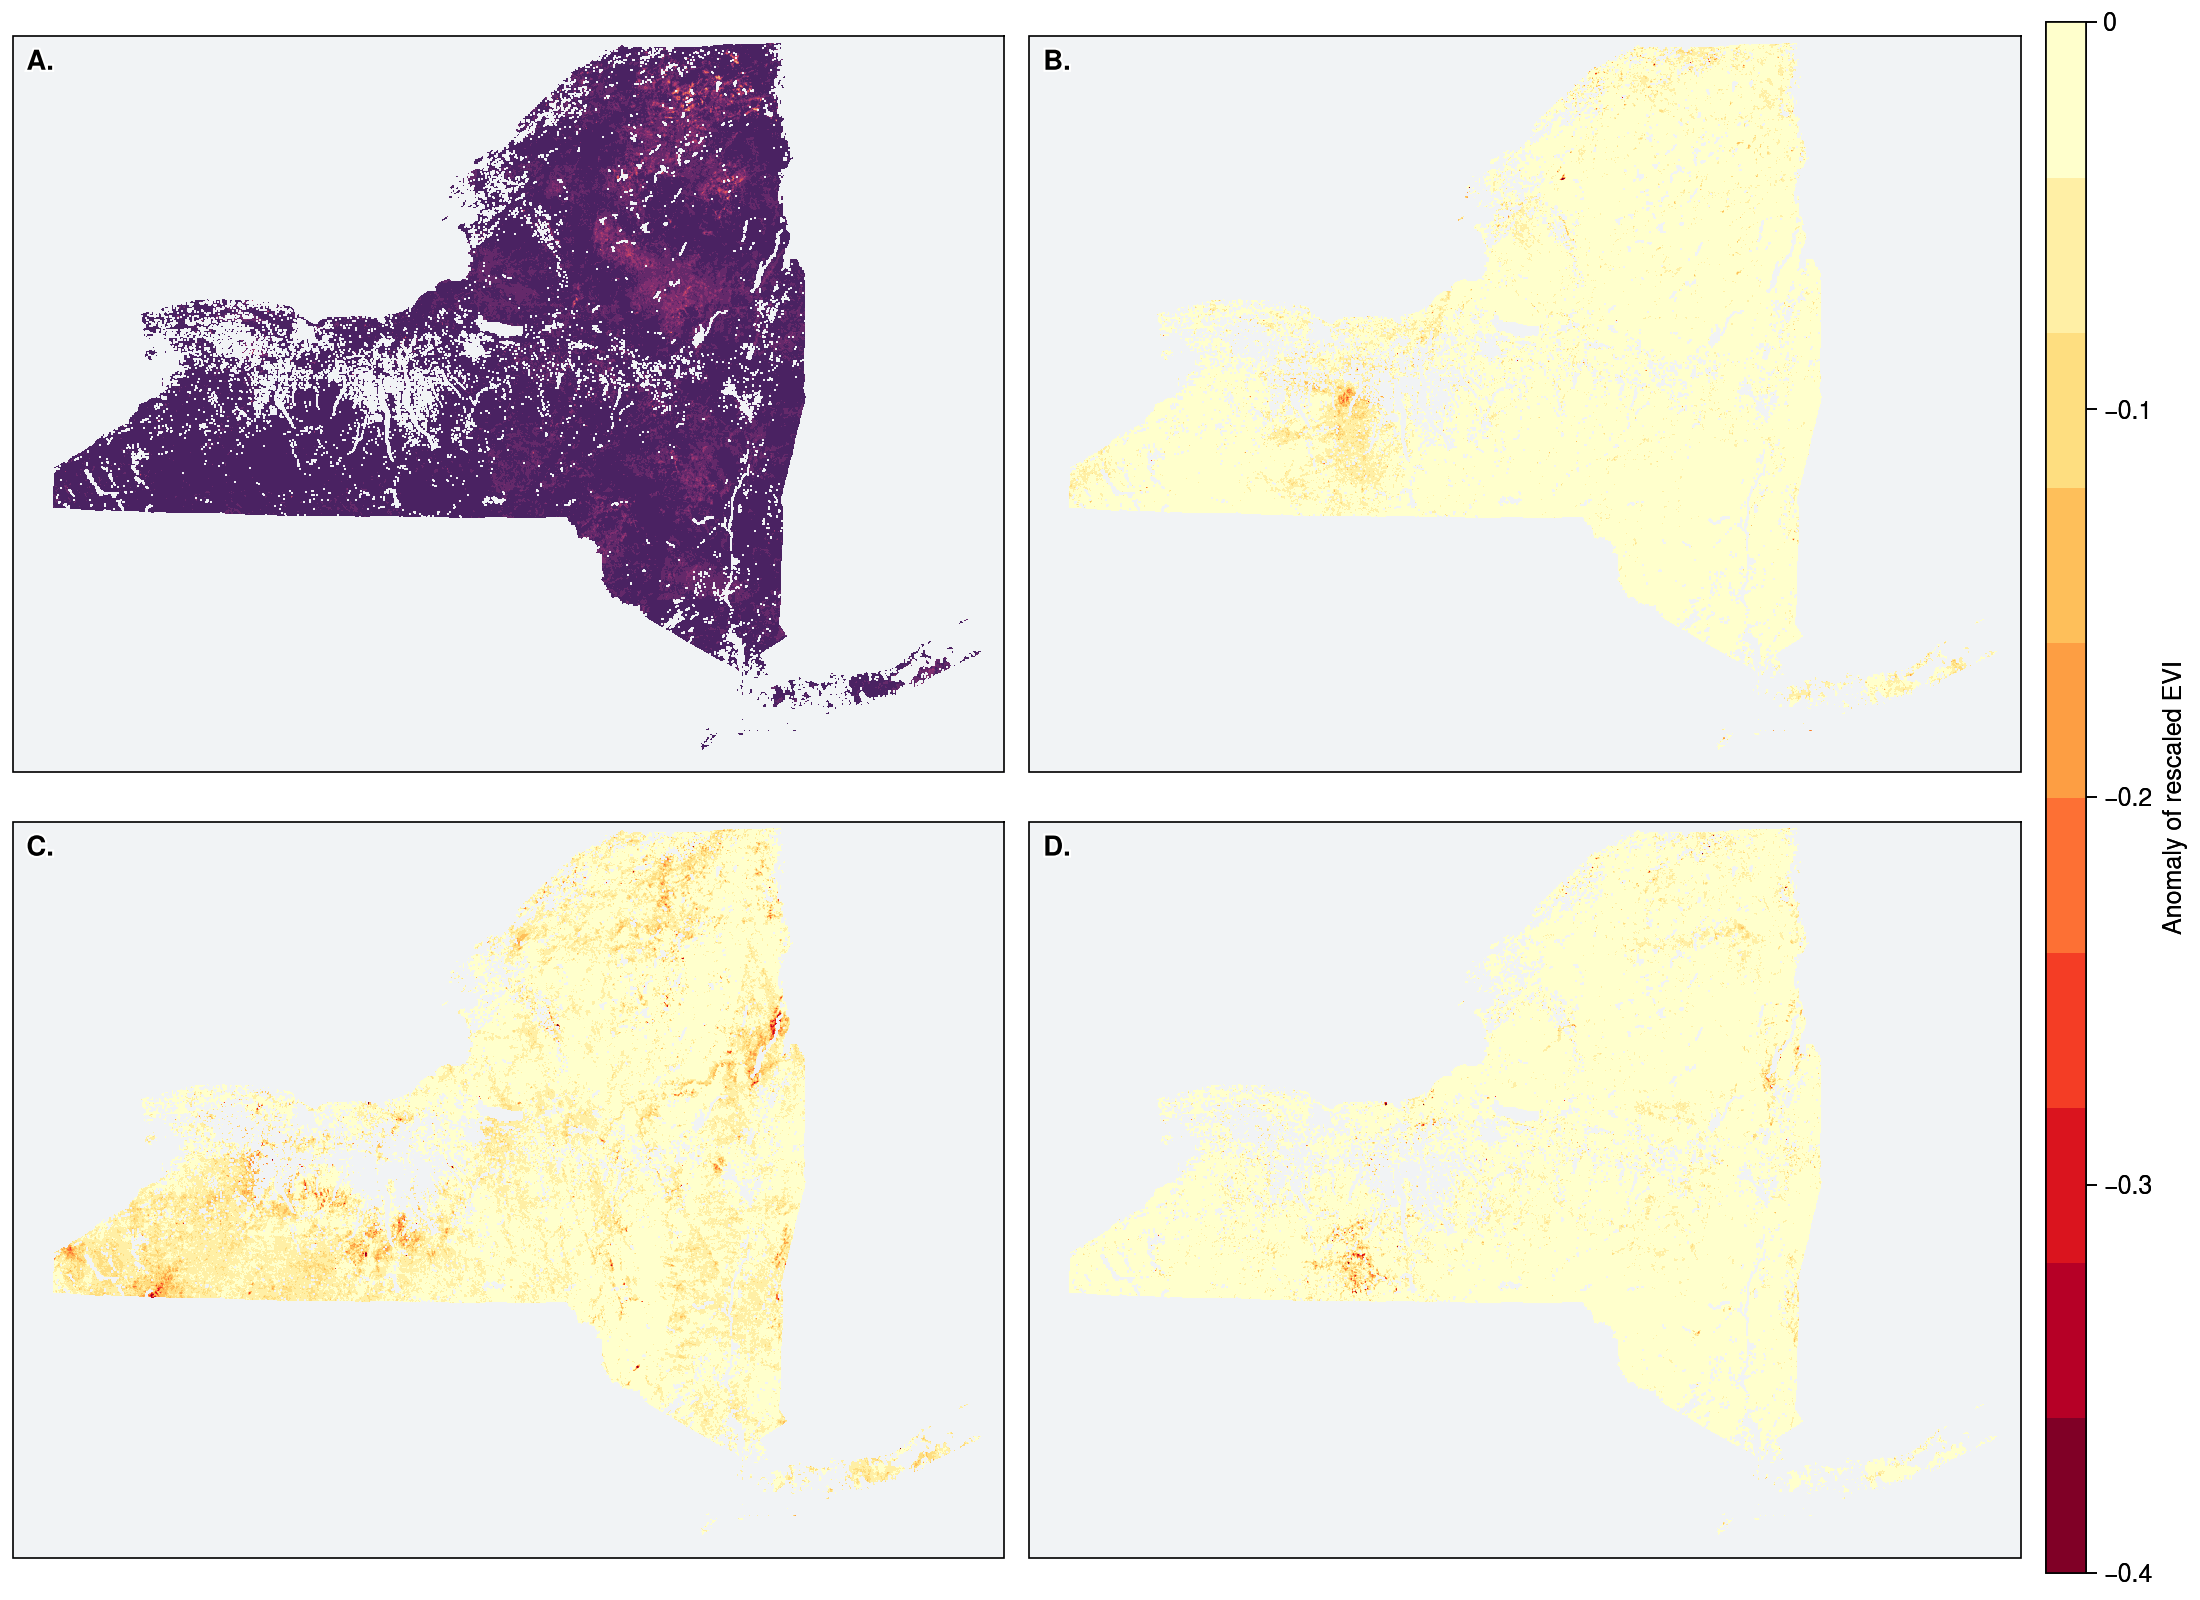

In [4]:
fig, axes = pplt.subplots(nrows=2, ncols=2, figsize=(11,8), proj=dest_crs, facecolor='white')

axes.format(abc='A.', abcloc='ul')

vmax = 0
vmin = -0.4

axes[0].imshow(image_2019[0], cmap='YlOrRd_r', levels=np.linspace(vmin, vmax, 11), transform=dest_crs,
               extent=[bounds_2019[0], bounds_2019[2], bounds_2019[1], bounds_2019[3]])
axes[0].set_extent([-80, -71.7, 40.3, 45], crs=ccrs.PlateCarree())
axes[0].format(grid=False, facecolor='gray1')

axes[1].imshow(image_2020[0], cmap='YlOrRd_r', levels=np.linspace(vmin, vmax, 11), transform=dest_crs,
               extent=[bounds_2020[0], bounds_2020[2], bounds_2020[1], bounds_2020[3]])
axes[1].set_extent([-80, -71.7, 40.3, 45], crs=ccrs.PlateCarree())
axes[1].format(grid=False, facecolor='gray1')

axes[2].imshow(image_2021[0], cmap='YlOrRd_r', levels=np.linspace(vmin, vmax, 11), transform=dest_crs,
               extent=[bounds_2021[0], bounds_2021[2], bounds_2021[1], bounds_2021[3]])
axes[2].set_extent([-80, -71.7, 40.3, 45], crs=ccrs.PlateCarree())
axes[2].format(grid=False, facecolor='gray1')

m = axes[3].imshow(image_2022[0], cmap='YlOrRd_r', levels=np.linspace(vmin, vmax, 11), transform=dest_crs,
                   extent=[bounds_2022[0], bounds_2022[2], bounds_2022[1], bounds_2022[3]])
axes[3].set_extent([-80, -71.7, 40.3, 45], crs=ccrs.PlateCarree())
axes[3].format(grid=False, facecolor='gray1')

fig.colorbar(m, label='Anomaly of rescaled EVI', ticks=0.1, loc='r')

fig.savefig('./Figures/year_map_upcaled.png')

C:\Users\camer\anaconda3\envs\bioee6550\lib\site-packages\cartopy\mpl\geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
C:\Users\camer\anaconda3\envs\bioee6550\lib\site-packages\cartopy\mpl\geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
C:\Users\camer\anaconda3\envs\bioee6550\lib\site-packages\cartopy\mpl\geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
C:\Users\camer\anaconda3\envs\bioee6550\lib\site-packages\cartopy\mpl\geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnin

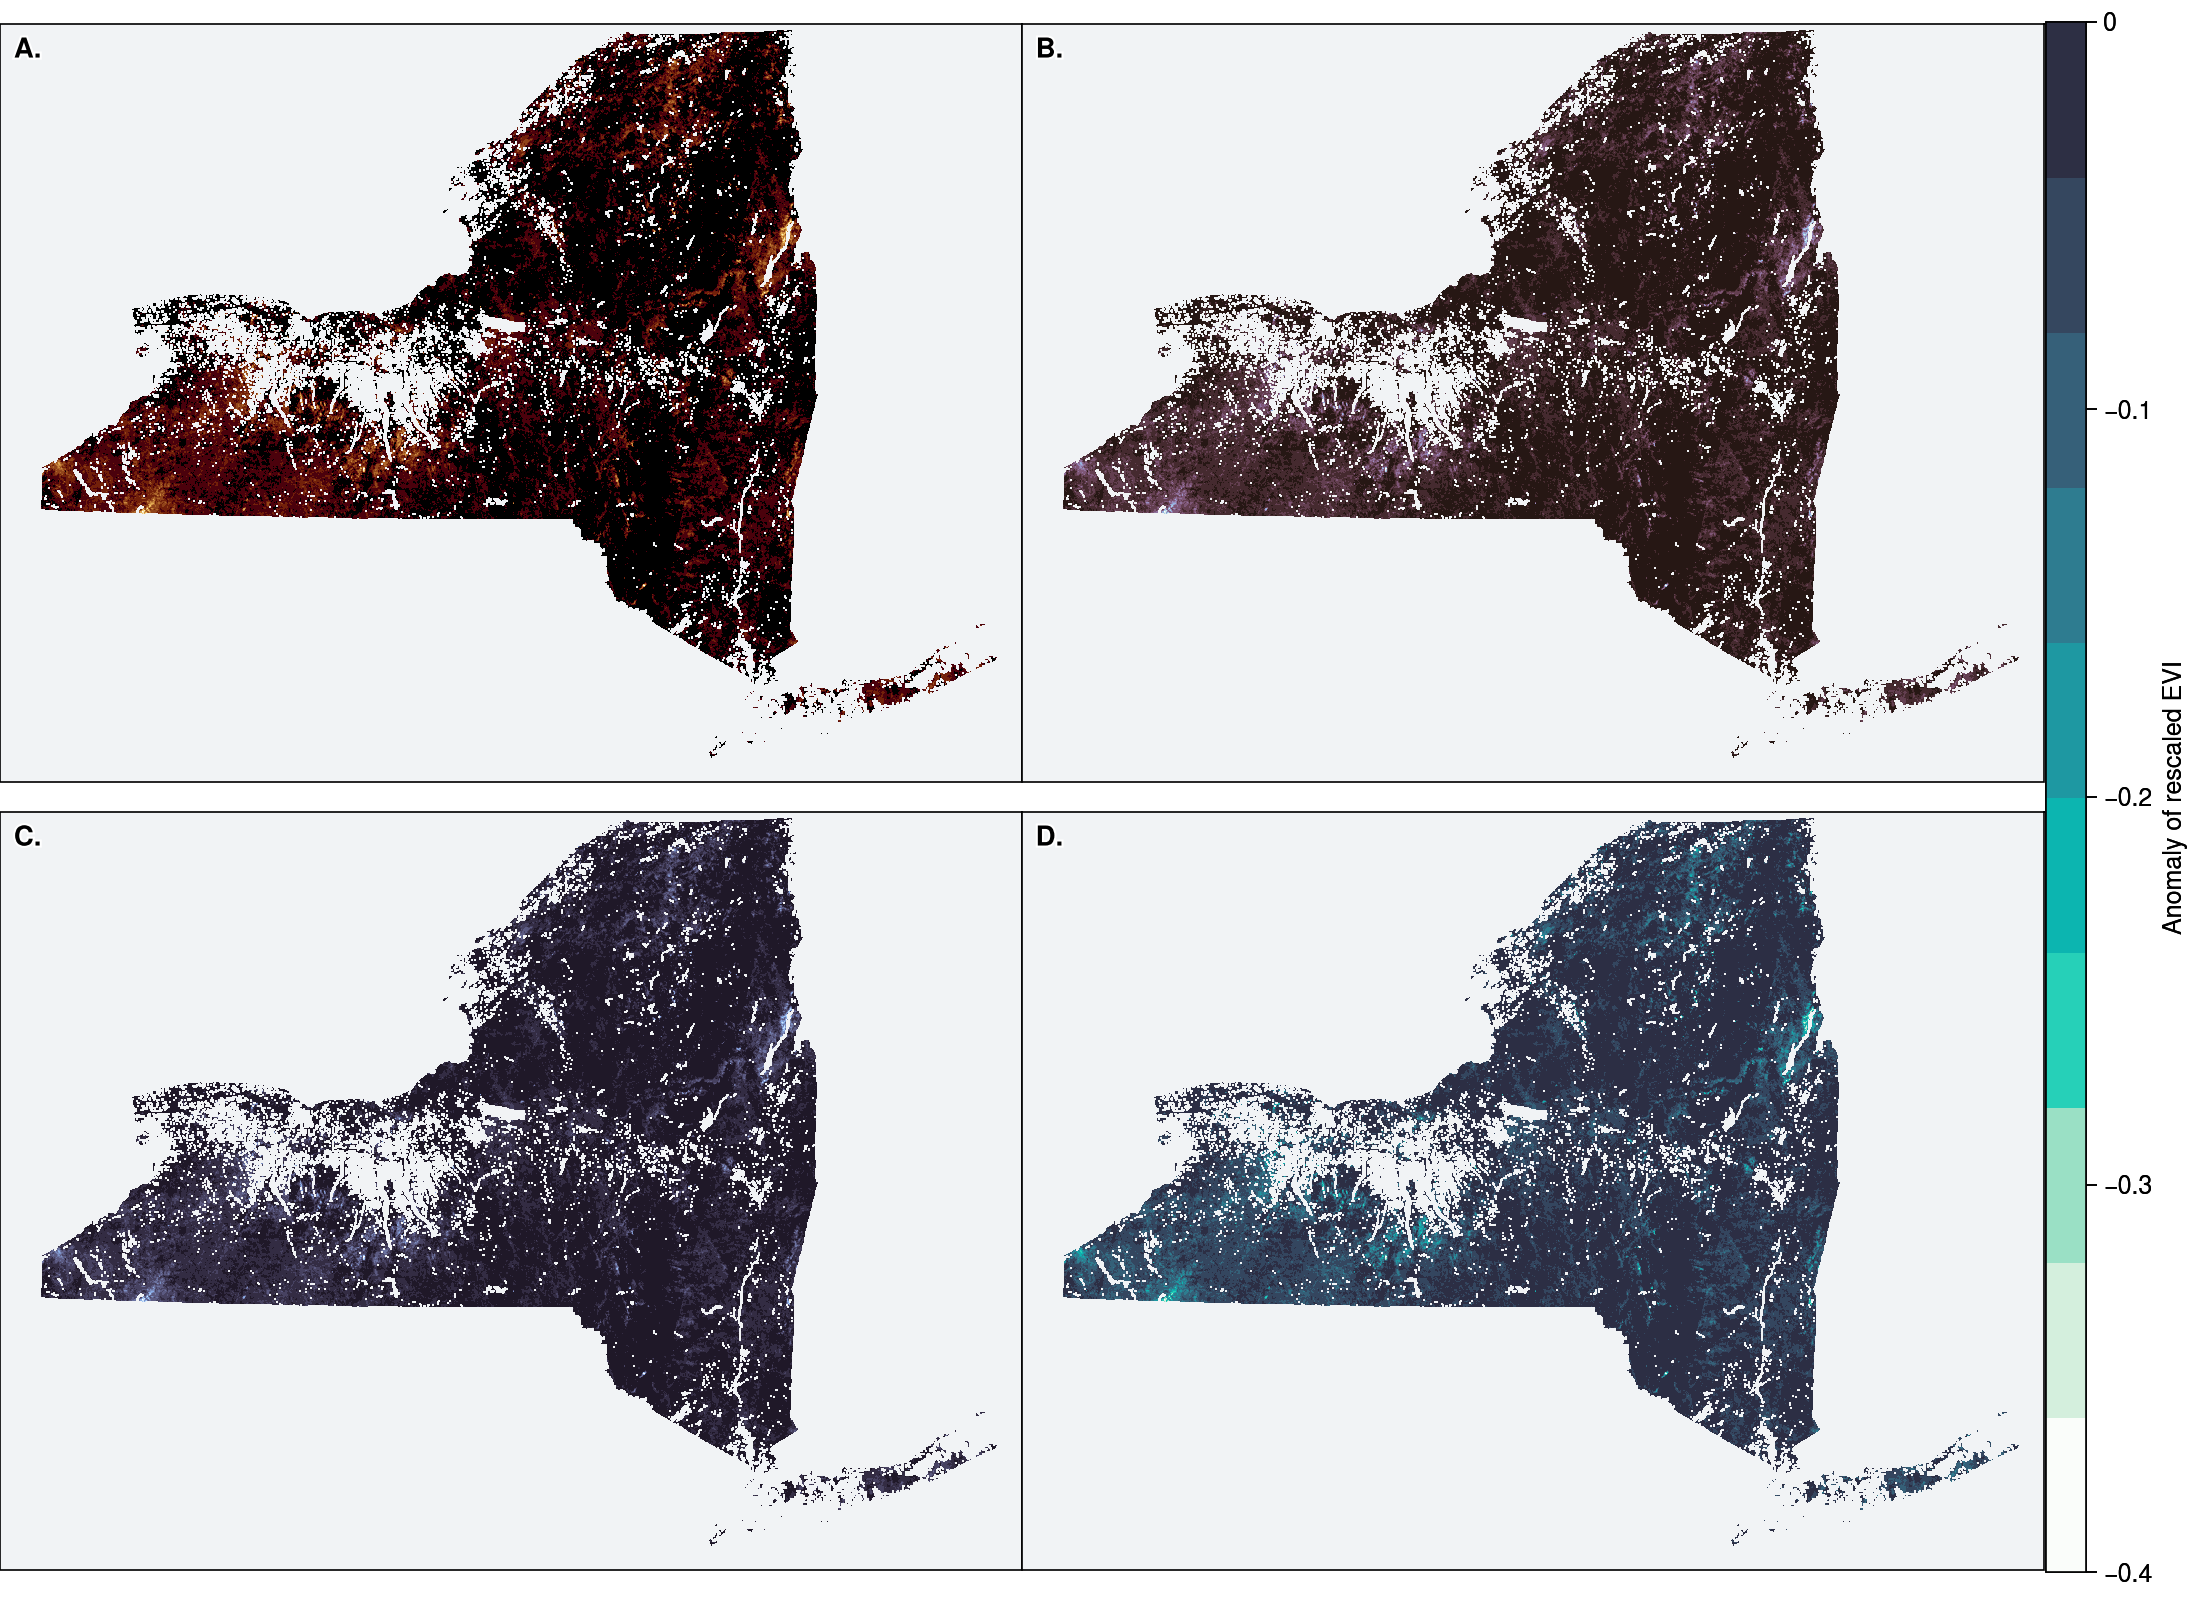

In [13]:
fig, axes = pplt.subplots(nrows=2, ncols=2, figsize=(11,8), proj=dest_crs, facecolor='white')

axes.format(abc='A.', abcloc='ul')

vmax = 0
vmin = -0.4

axes[0].imshow(image_2021[0], cmap='Stellar', levels=np.linspace(vmin, vmax, 11), transform=dest_crs,
               extent=[bounds_2021[0], bounds_2021[2], bounds_2021[1], bounds_2021[3]])
axes[0].set_extent([-80, -71.7, 40.3, 45], crs=ccrs.PlateCarree())
axes[0].format(grid=False, facecolor='gray1')

axes[1].imshow(image_2021[0], cmap='Glacial', levels=np.linspace(vmin, vmax, 11), transform=dest_crs,
               extent=[bounds_2021[0], bounds_2021[2], bounds_2021[1], bounds_2021[3]])
axes[1].set_extent([-80, -71.7, 40.3, 45], crs=ccrs.PlateCarree())
axes[1].format(grid=False, facecolor='gray1')

axes[2].imshow(image_2021[0], cmap='Dusk', levels=np.linspace(vmin, vmax, 11), transform=dest_crs,
               extent=[bounds_2021[0], bounds_2021[2], bounds_2021[1], bounds_2021[3]])
axes[2].set_extent([-80, -71.7, 40.3, 45], crs=ccrs.PlateCarree())
axes[2].format(grid=False, facecolor='gray1')

m = axes[3].imshow(image_2021[0], cmap='Marine', levels=np.linspace(vmin, vmax, 11), transform=dest_crs,
                   extent=[bounds_2021[0], bounds_2021[2], bounds_2021[1], bounds_2021[3]])
axes[3].set_extent([-80, -71.7, 40.3, 45], crs=ccrs.PlateCarree())
axes[3].format(grid=False, facecolor='gray1')

fig.colorbar(m, label='Anomaly of rescaled EVI', ticks=0.1, loc='r')

#fig.savefig('./Figures/year_map_upcaled.png')

C:\Users\camer\anaconda3\envs\bioee6550\lib\site-packages\cartopy\mpl\geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
C:\Users\camer\anaconda3\envs\bioee6550\lib\site-packages\cartopy\mpl\geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


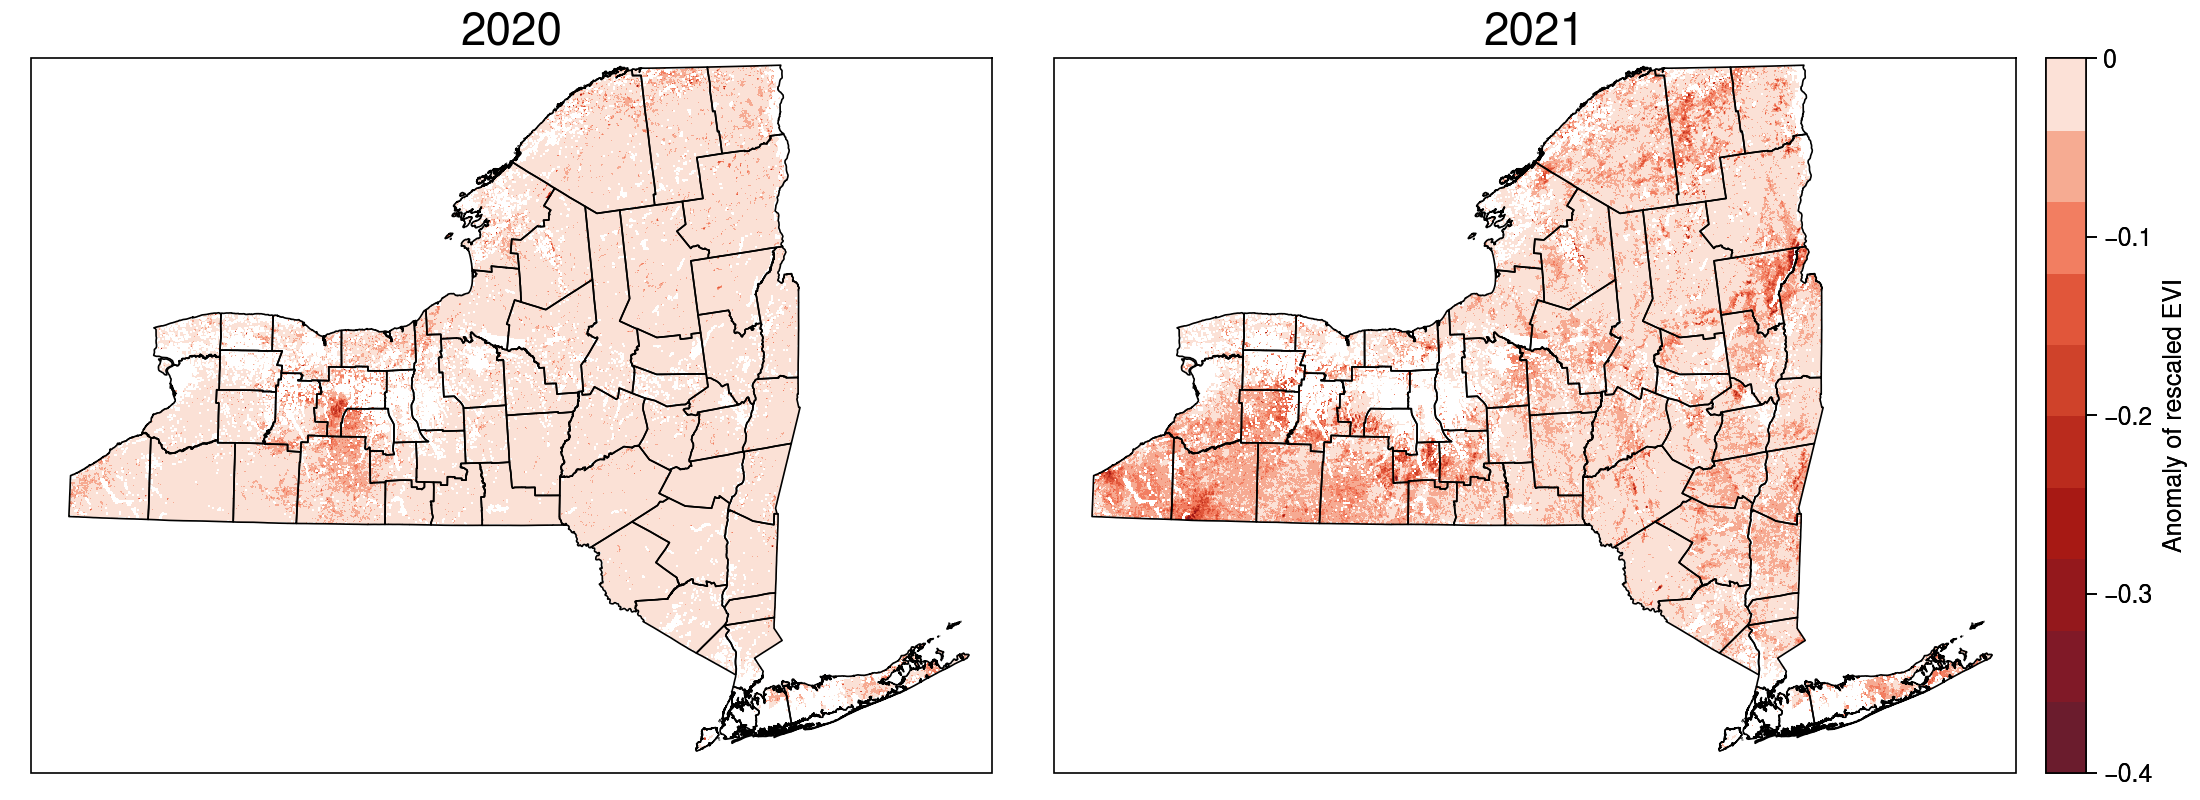

In [36]:
fig, axes = pplt.subplots(nrows=1, ncols=2, figsize=(11,4), proj=dest_crs, facecolor='white', fontsize=15)

#axes.format(abc='A.', abcloc='ul')

vmax = 0
vmin = -0.4

axes[0].imshow(image_2020[0], cmap='Reds3_r', levels=np.linspace(vmin, vmax, 11), transform=dest_crs,
               extent=[bounds_2020[0], bounds_2020[2], bounds_2020[1], bounds_2020[3]])
axes[0].set_extent([-80, -71.7, 40.3, 45], crs=ccrs.PlateCarree())
axes[0].format(grid=False, facecolor='white', title=2020)

for row in county_2019.itertuples():
    region = ShapelyFeature(row.geometry,
                            ccrs.PlateCarree(),
                            facecolor='none',
                            edgecolor='black'
                           )
    axes[0].add_feature(region)

m = axes[1].imshow(image_2021[0], cmap='Reds3_r', levels=np.linspace(vmin, vmax, 11), transform=dest_crs,
               extent=[bounds_2021[0], bounds_2021[2], bounds_2021[1], bounds_2021[3]])
axes[1].set_extent([-80, -71.7, 40.3, 45], crs=ccrs.PlateCarree())
axes[1].format(grid=False, facecolor='white', title=2021)

for row in county_2019.itertuples():
    region = ShapelyFeature(row.geometry,
                            ccrs.PlateCarree(),
                            facecolor='none',
                            edgecolor='black'
                           )
    axes[1].add_feature(region)

fig.colorbar(m, label='Anomaly of rescaled EVI', ticks=0.1, loc='r')

#fig.savefig('./Figures/year_map_upcaled.png')

C:\Users\camer\anaconda3\envs\bioee6550\lib\site-packages\cartopy\mpl\geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
C:\Users\camer\anaconda3\envs\bioee6550\lib\site-packages\cartopy\mpl\geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
C:\Users\camer\anaconda3\envs\bioee6550\lib\site-packages\cartopy\mpl\geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
C:\Users\camer\anaconda3\envs\bioee6550\lib\site-packages\cartopy\mpl\geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnin

TypeError: _parse_colorbar_ticks() got multiple values for keyword argument 'fontsize'

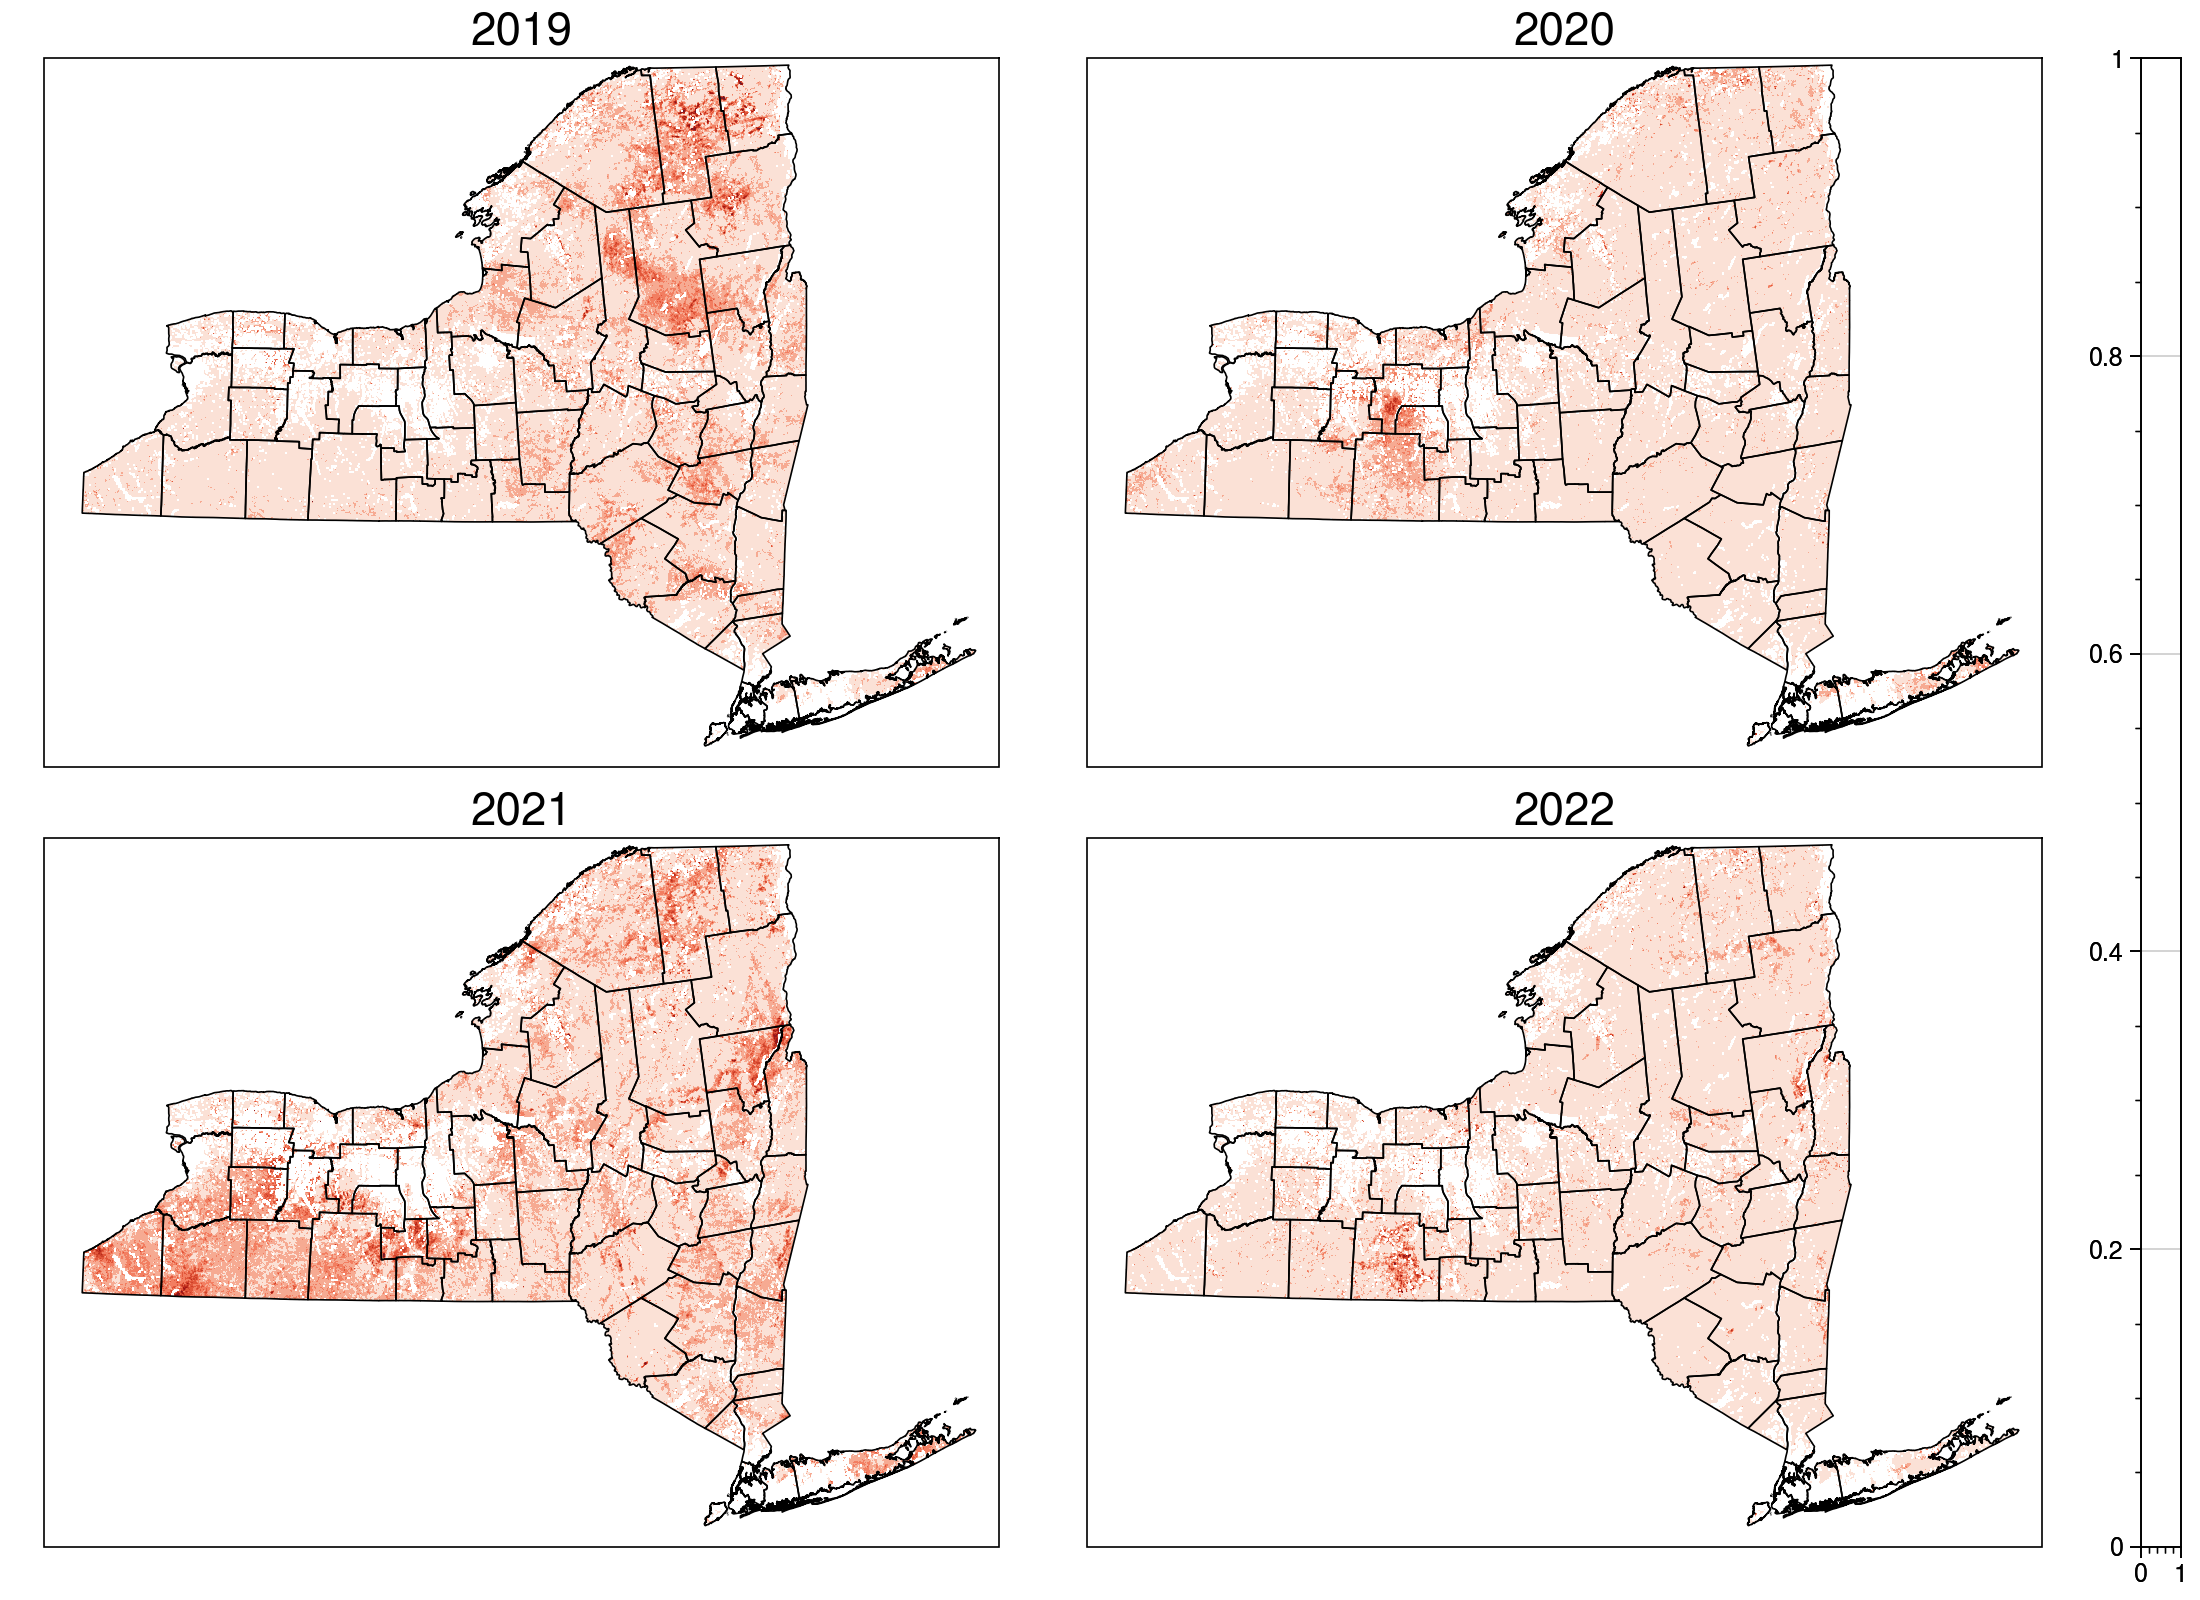

In [12]:
dest_crs = ccrs.LambertConformal(central_longitude=-76.0, central_latitude=42.0,)

fig, axes = pplt.subplots(nrows=2, ncols=2, figsize=(11,8), proj=dest_crs, facecolor='white', fontsize=15)

#axes.format(abc='A.', abcloc='ul')

vmax = 0
vmin = -0.4

axes[0].imshow(image_2019[0], cmap='Reds3_r', levels=np.linspace(vmin, vmax, 11), transform=dest_crs,
               extent=[bounds_2019[0], bounds_2019[2], bounds_2019[1], bounds_2019[3]])
axes[0].set_extent([-80, -71.7, 40.3, 45], crs=ccrs.PlateCarree())
axes[0].format(grid=False, facecolor='white', title=2019)



axes[1].imshow(image_2020[0], cmap='Reds3_r', levels=np.linspace(vmin, vmax, 11), transform=dest_crs,
               extent=[bounds_2020[0], bounds_2020[2], bounds_2020[1], bounds_2020[3]])
axes[1].set_extent([-80, -71.7, 40.3, 45], crs=ccrs.PlateCarree())
axes[1].format(grid=False, facecolor='white', title=2020)


m = axes[2].imshow(image_2021[0], cmap='Reds3_r', levels=np.linspace(vmin, vmax, 11), transform=dest_crs,
               extent=[bounds_2021[0], bounds_2021[2], bounds_2021[1], bounds_2021[3]])
axes[2].set_extent([-80, -71.7, 40.3, 45], crs=ccrs.PlateCarree())
axes[2].format(grid=False, facecolor='white', title=2021)

    
axes[3].imshow(image_2022[0], cmap='Reds3_r', levels=np.linspace(vmin, vmax, 11), transform=dest_crs,
               extent=[bounds_2022[0], bounds_2022[2], bounds_2022[1], bounds_2022[3]])
axes[3].set_extent([-80, -71.7, 40.3, 45], crs=ccrs.PlateCarree())
axes[3].format(grid=False, facecolor='white', title=2022)


# Overlay County Outlines
for row in county_2019.itertuples():
    region = ShapelyFeature(row.geometry,
                            ccrs.PlateCarree(),
                            facecolor='none',
                            edgecolor='black'
                           )
    for ax in axes:
        ax.add_feature(region) 

fig.colorbar(m, label='Anomaly of rescaled EVI', ticks=0.1, loc='r')

fig.savefig('./Figures/New_York_Defoliation_All_Years.png')

In [7]:
def expand(x):
    if x.geometry.geom_type == 'Polygon':
        return [x.geometry]
    else: 
        return [g for g in x.geometry.geoms]
        
county_2019["geometries"] = county_2019.apply(expand, axis=1)
county_2019 = county_2019.explode(column="geometries").drop(columns="geometry").set_geometry("geometries").rename_geometry("geometry")

county_2020["geometries"] = county_2020.apply(expand, axis=1)
county_2020 = county_2020.explode(column="geometries").drop(columns="geometry").set_geometry("geometries").rename_geometry("geometry")

county_2021["geometries"] = county_2021.apply(expand, axis=1)
county_2021 = county_2021.explode(column="geometries").drop(columns="geometry").set_geometry("geometries").rename_geometry("geometry")

county_2022["geometries"] = county_2022.apply(expand, axis=1)
county_2022 = county_2022.explode(column="geometries").drop(columns="geometry").set_geometry("geometries").rename_geometry("geometry")

C:\Users\camer\anaconda3\envs\bioee6550\lib\site-packages\cartopy\mpl\geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
C:\Users\camer\anaconda3\envs\bioee6550\lib\site-packages\cartopy\mpl\geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
C:\Users\camer\anaconda3\envs\bioee6550\lib\site-packages\cartopy\mpl\geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
C:\Users\camer\anaconda3\envs\bioee6550\lib\site-packages\cartopy\mpl\geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnin

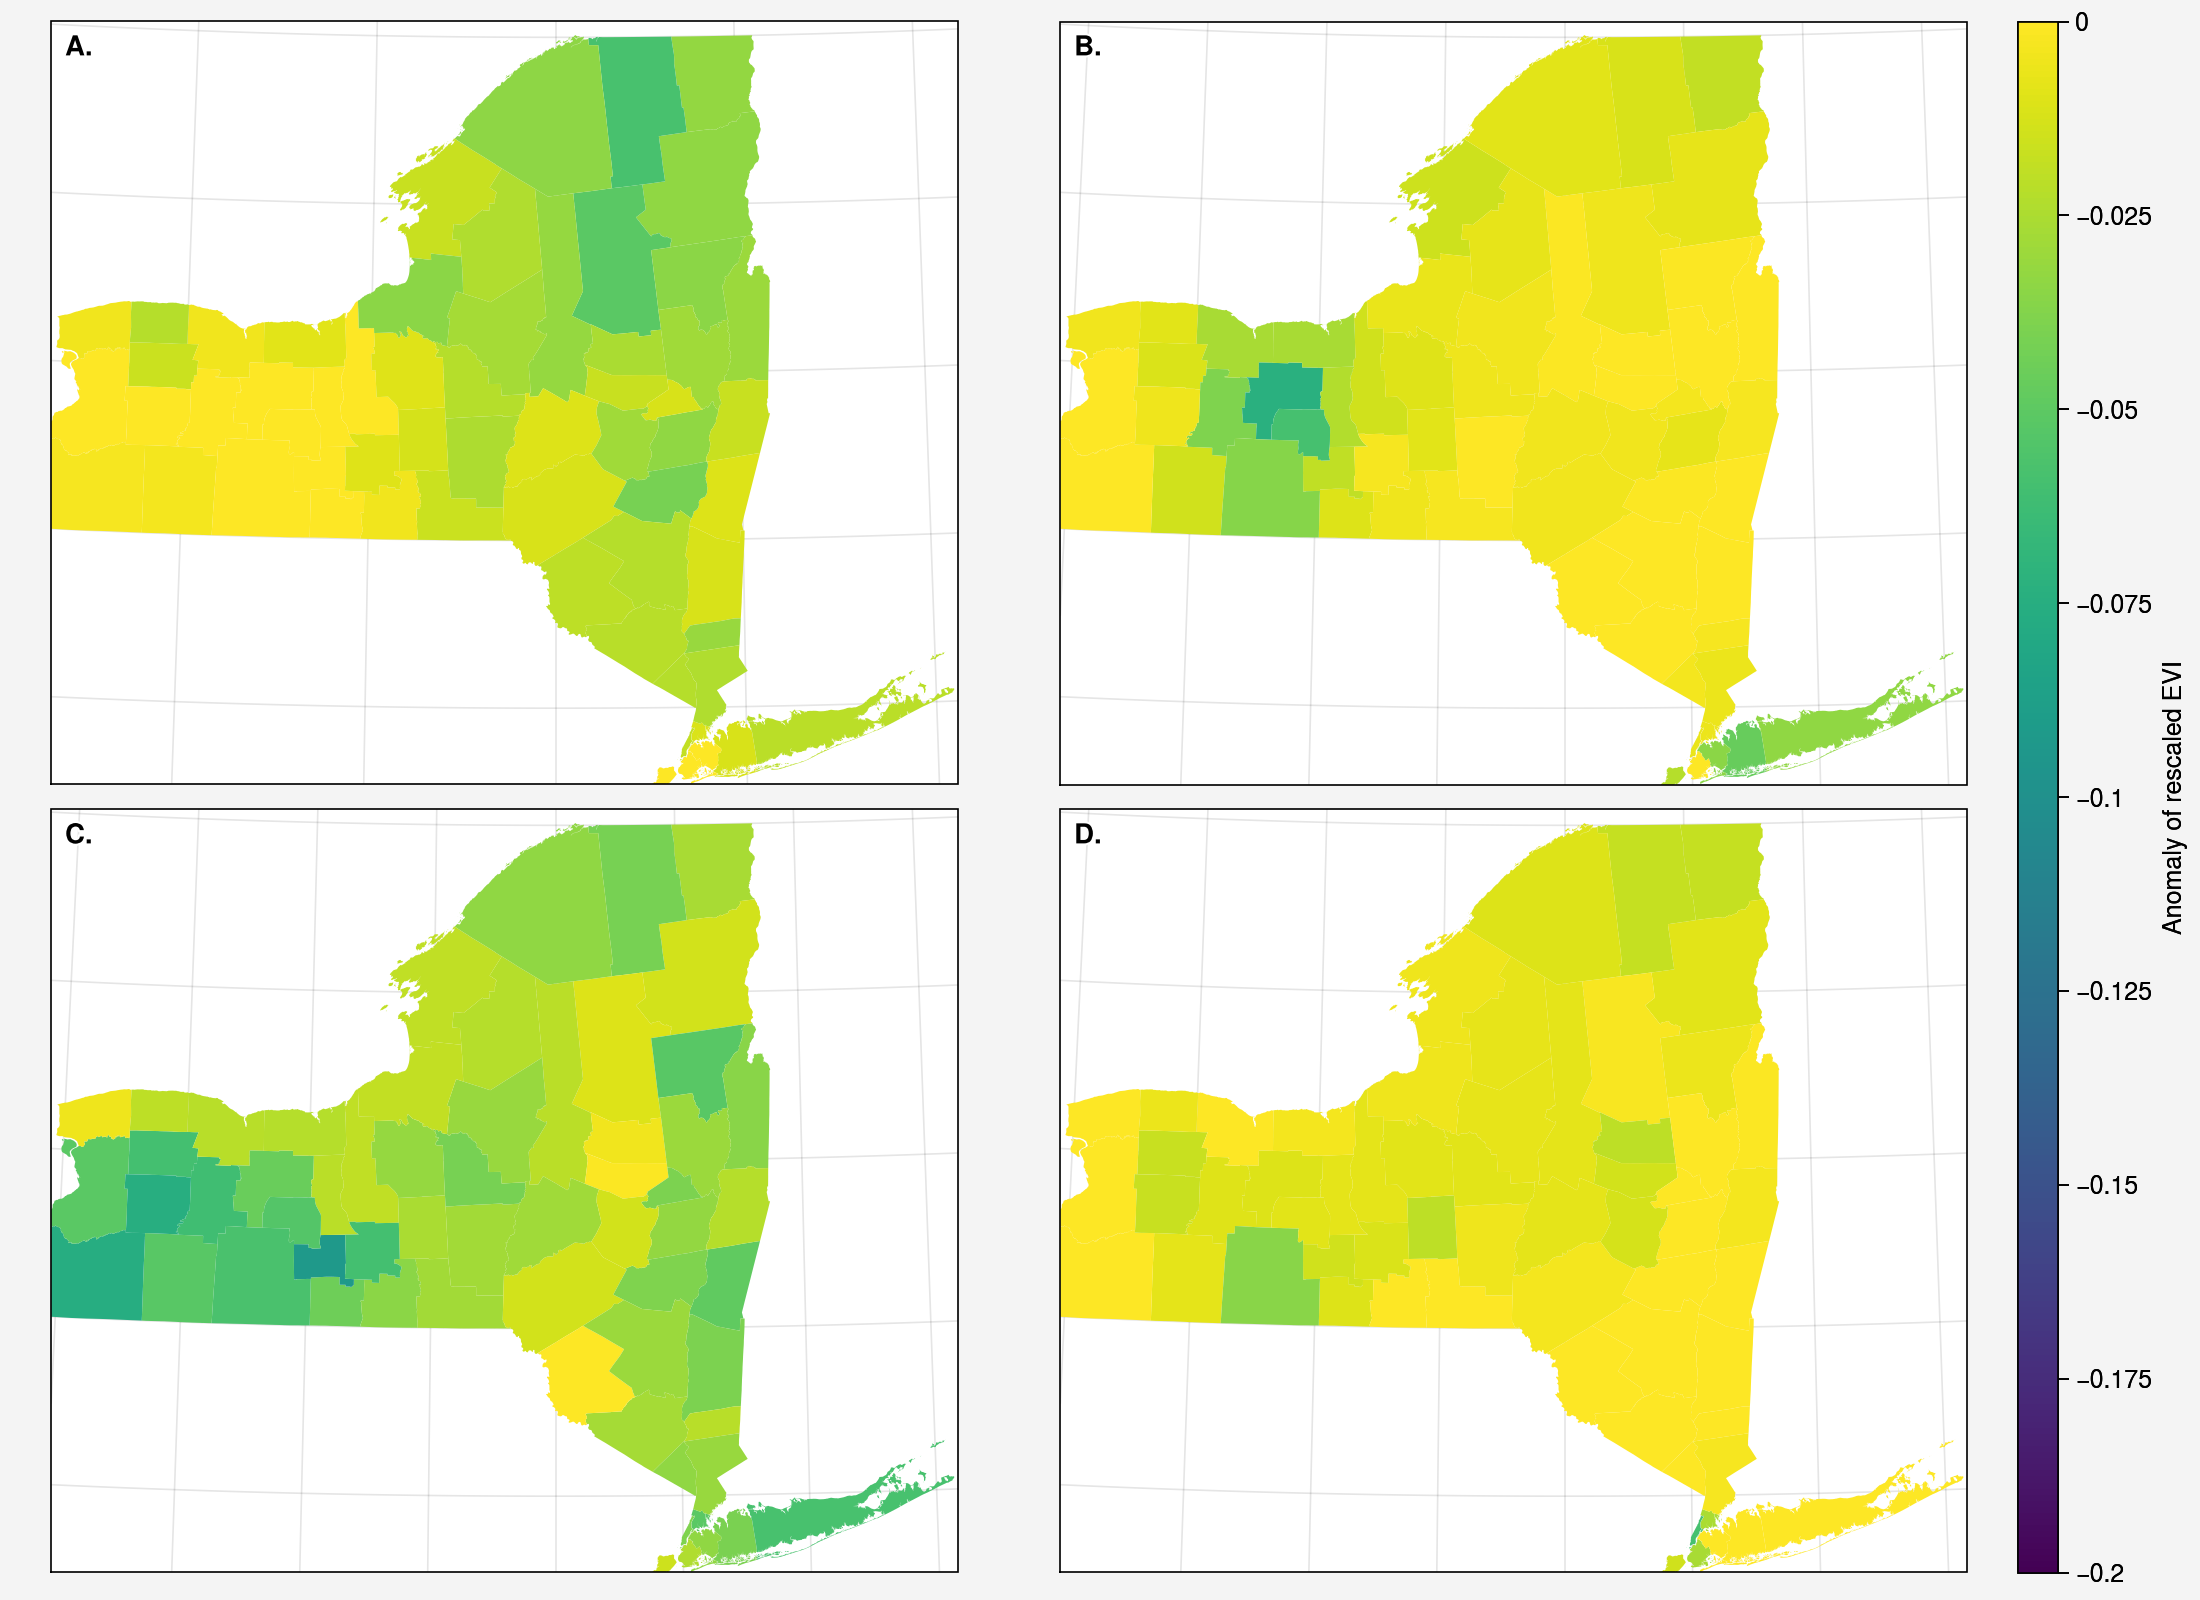

In [7]:
fig, axes = pplt.subplots(nrows=2, ncols=2, proj=ccrs.epsg(32618), figsize=(11, 8))

axes.format(abc='A.', abcloc='ul')

norm = plt.colors.Normalize(vmin=-0.2, vmax=0)
cmap = plt.cm.viridis

for row in county_2019.itertuples():
    region = ShapelyFeature(row.geometry,
                            ccrs.PlateCarree(),
                            facecolor=cmap(norm(row.mean))
                           )
    axes[0].add_feature(region)
axes[0].set_extent([-80, -71.85616396303963, 40.502009391283906, 45.01550900568005], crs=ccrs.PlateCarree())

for row in county_2020.itertuples():
    region = ShapelyFeature(row.geometry,
                            ccrs.PlateCarree(),
                            facecolor=cmap(norm(row.mean))
                           )
    axes[1].add_feature(region)
axes[1].set_extent([-79.7633786294863, -71.85616396303963, 40.502009391283906, 45.01550900568005], crs=ccrs.PlateCarree())

for row in county_2021.itertuples():
    region = ShapelyFeature(row.geometry,
                            ccrs.PlateCarree(),
                            facecolor=cmap(norm(row.mean))
                           )
    axes[2].add_feature(region)
axes[2].set_extent([-79.7633786294863, -71.85616396303963, 40.502009391283906, 45.01550900568005], crs=ccrs.PlateCarree())

for row in county_2022.itertuples():
    region = ShapelyFeature(row.geometry,
                            ccrs.PlateCarree(),
                            facecolor=cmap(norm(row.mean))
                           )
    axes[3].add_feature(region)
axes[3].set_extent([-79.7633786294863, -71.85616396303963, 40.502009391283906, 45.01550900568005], crs=ccrs.PlateCarree())

fig.colorbar(cmap, norm=norm, label='Anomaly of rescaled EVI')

fig.savefig('./Figures/year_map_counties.png')

# Figure 5 - Intra-annual patterns

In [ ]:
new_york_2019 = rio.open('./Data/upscaled_pheno_2019.tif', 'r')
new_york_2020 = rio.open('./Data/upscaled_pheno_2020.tif', 'r')
new_york_2021 = rio.open('./Data/upscaled_pheno_2021.tif', 'r')
new_york_2022 = rio.open('./Data/upscaled_pheno_2022.tif', 'r')

county_2019 = gpd.read_file('./Data/counties_pheno_2019.geojson')
county_2020 = gpd.read_file('./Data/counties_pheno_2020.geojson')
county_2021 = gpd.read_file('./Data/counties_pheno_2021.geojson')
county_2022 = gpd.read_file('./Data/counties_pheno_2022.geojson')

In [ ]:
data_2019 = new_york_2019.read()
data_2020 = new_york_2020.read()
data_2021 = new_york_2021.read()
data_2022 = new_york_2022.read()

In [ ]:
fig, axes = pplt.subplots(nrows=2, ncols=2, figsize=(11,8), proj=ccrs.epsg(32618))

axes.format(abc='A.', abcloc='ul')

vmax = 230
vmin = 180

axes[0].imshow(data_2019[0], cmap='viridis', levels=np.linspace(vmin, vmax, 11), transform=ccrs.epsg(32618), 
               extent=[new_york_2019.bounds.left, new_york_2019.bounds.right, new_york_2019.bounds.bottom, new_york_2019.bounds.top])
axes[0].set_extent([-79.8, -71.85616396303963, 40.502009391283906, 45.01550900568005], crs=ccrs.PlateCarree())

axes[1].imshow(data_2020[0], cmap='viridis', levels=np.linspace(vmin, vmax, 11), transform=ccrs.epsg(32618),
               extent=[new_york_2020.bounds.left, new_york_2020.bounds.right, new_york_2020.bounds.bottom, new_york_2020.bounds.top])
axes[1].set_extent([-79.8, -71.85616396303963, 40.502009391283906, 45.01550900568005], crs=ccrs.PlateCarree())

axes[2].imshow(data_2021[0], cmap='viridis', levels=np.linspace(vmin, vmax, 11), transform=ccrs.epsg(32618),
               extent=[new_york_2021.bounds.left, new_york_2021.bounds.right, new_york_2021.bounds.bottom, new_york_2021.bounds.top])
axes[2].set_extent([-79.8, -71.85616396303963, 40.502009391283906, 45.01550900568005], crs=ccrs.PlateCarree())

m = axes[3].imshow(data_2022[0], cmap='viridis', levels=np.linspace(vmin, vmax, 11), transform=ccrs.epsg(32618),
                   extent=[new_york_2022.bounds.left, new_york_2022.bounds.right, new_york_2022.bounds.bottom, new_york_2022.bounds.top])
axes[3].set_extent([-79.8, -71.85616396303963, 40.502009391283906, 45.01550900568005], crs=ccrs.PlateCarree())

fig.colorbar(m, label='Start Date of Defoliation', ticks=5, loc='r')

#fig.savefig('./Figures/year_map_upcaled.png')

In [ ]:
fig, axes = pplt.subplots(nrows=2, ncols=2, figsize=(11,8), proj=ccrs.epsg(32618))

axes.format(abc='A.', abcloc='ul')

vmax = 260
vmin = 180

axes[0].imshow(data_2019[1], cmap='viridis', levels=np.linspace(vmin, vmax, 11), transform=ccrs.epsg(32618), 
               extent=[new_york_2019.bounds.left, new_york_2019.bounds.right, new_york_2019.bounds.bottom, new_york_2019.bounds.top])
axes[0].set_extent([-79.8, -71.85616396303963, 40.502009391283906, 45.01550900568005], crs=ccrs.PlateCarree())

axes[1].imshow(data_2020[1], cmap='viridis', levels=np.linspace(vmin, vmax, 11), transform=ccrs.epsg(32618),
               extent=[new_york_2020.bounds.left, new_york_2020.bounds.right, new_york_2020.bounds.bottom, new_york_2020.bounds.top])
axes[1].set_extent([-79.8, -71.85616396303963, 40.502009391283906, 45.01550900568005], crs=ccrs.PlateCarree())

axes[2].imshow(data_2021[1], cmap='viridis', levels=np.linspace(vmin, vmax, 11), transform=ccrs.epsg(32618),
               extent=[new_york_2021.bounds.left, new_york_2021.bounds.right, new_york_2021.bounds.bottom, new_york_2021.bounds.top])
axes[2].set_extent([-79.8, -71.85616396303963, 40.502009391283906, 45.01550900568005], crs=ccrs.PlateCarree())

m = axes[3].imshow(data_2022[1], cmap='viridis', levels=np.linspace(vmin, vmax, 11), transform=ccrs.epsg(32618),
                   extent=[new_york_2022.bounds.left, new_york_2022.bounds.right, new_york_2022.bounds.bottom, new_york_2022.bounds.top])
axes[3].set_extent([-79.8, -71.85616396303963, 40.502009391283906, 45.01550900568005], crs=ccrs.PlateCarree())

fig.colorbar(m, label='End Date of Defoliation', ticks=5, loc='r')

#fig.savefig('./Figures/year_map_upcaled.png')

In [ ]:
fig, axes = pplt.subplots(nrows=2, ncols=2, figsize=(11,8), proj=ccrs.epsg(32618))

axes.format(abc='A.', abcloc='ul')

vmax = 230
vmin = 160

axes[0].imshow(data_2019[2], cmap='viridis', levels=np.linspace(vmin, vmax, 11), transform=ccrs.epsg(32618), 
               extent=[new_york_2019.bounds.left, new_york_2019.bounds.right, new_york_2019.bounds.bottom, new_york_2019.bounds.top])
axes[0].set_extent([-79.8, -71.85616396303963, 40.502009391283906, 45.01550900568005], crs=ccrs.PlateCarree())

axes[1].imshow(data_2020[2], cmap='viridis', levels=np.linspace(vmin, vmax, 11), transform=ccrs.epsg(32618),
               extent=[new_york_2020.bounds.left, new_york_2020.bounds.right, new_york_2020.bounds.bottom, new_york_2020.bounds.top])
axes[1].set_extent([-79.8, -71.85616396303963, 40.502009391283906, 45.01550900568005], crs=ccrs.PlateCarree())

axes[2].imshow(data_2021[2], cmap='viridis', levels=np.linspace(vmin, vmax, 11), transform=ccrs.epsg(32618),
               extent=[new_york_2021.bounds.left, new_york_2021.bounds.right, new_york_2021.bounds.bottom, new_york_2021.bounds.top])
axes[2].set_extent([-79.8, -71.85616396303963, 40.502009391283906, 45.01550900568005], crs=ccrs.PlateCarree())

m = axes[3].imshow(data_2022[2], cmap='viridis', levels=np.linspace(vmin, vmax, 11), transform=ccrs.epsg(32618),
                   extent=[new_york_2022.bounds.left, new_york_2022.bounds.right, new_york_2022.bounds.bottom, new_york_2022.bounds.top])
axes[3].set_extent([-79.8, -71.85616396303963, 40.502009391283906, 45.01550900568005], crs=ccrs.PlateCarree())

fig.colorbar(m, label='Peak Date of Defoliation', ticks=5, loc='r')

#fig.savefig('./Figures/year_map_upcaled.png')

In [ ]:
def expand(x):
    if x.geometry.geom_type == 'Polygon':
        return [x.geometry]
    else: 
        return [g for g in x.geometry.geoms]
        
county_2019["geometries"] = county_2019.apply(expand, axis=1)
county_2019 = county_2019.explode(column="geometries").drop(columns="geometry").set_geometry("geometries").rename_geometry("geometry")

county_2020["geometries"] = county_2020.apply(expand, axis=1)
county_2020 = county_2020.explode(column="geometries").drop(columns="geometry").set_geometry("geometries").rename_geometry("geometry")

county_2021["geometries"] = county_2021.apply(expand, axis=1)
county_2021 = county_2021.explode(column="geometries").drop(columns="geometry").set_geometry("geometries").rename_geometry("geometry")

county_2022["geometries"] = county_2022.apply(expand, axis=1)
county_2022 = county_2022.explode(column="geometries").drop(columns="geometry").set_geometry("geometries").rename_geometry("geometry")

In [ ]:
fig, axes = pplt.subplots(nrows=2, ncols=2, proj=ccrs.epsg(32618), figsize=(11, 8))

axes.format(abc='A.', abcloc='ul')

norm = plt.colors.Normalize(vmin=180, vmax=230)
cmap = plt.cm.viridis

for row in county_2019.itertuples():
    region = ShapelyFeature(row.geometry,
                            ccrs.PlateCarree(),
                            facecolor=cmap(norm(row.start_date))
                           )
    axes[0].add_feature(region)
axes[0].set_extent([-80, -71.85616396303963, 40.502009391283906, 45.01550900568005], crs=ccrs.PlateCarree())

for row in county_2020.itertuples():
    region = ShapelyFeature(row.geometry,
                            ccrs.PlateCarree(),
                            facecolor=cmap(norm(row.start_date))
                           )
    axes[1].add_feature(region)
axes[1].set_extent([-79.7633786294863, -71.85616396303963, 40.502009391283906, 45.01550900568005], crs=ccrs.PlateCarree())

for row in county_2021.itertuples():
    region = ShapelyFeature(row.geometry,
                            ccrs.PlateCarree(),
                            facecolor=cmap(norm(row.start_date))
                           )
    axes[2].add_feature(region)
axes[2].set_extent([-79.7633786294863, -71.85616396303963, 40.502009391283906, 45.01550900568005], crs=ccrs.PlateCarree())

for row in county_2022.itertuples():
    region = ShapelyFeature(row.geometry,
                            ccrs.PlateCarree(),
                            facecolor=cmap(norm(row.start_date))
                           )
    axes[3].add_feature(region)
axes[3].set_extent([-79.7633786294863, -71.85616396303963, 40.502009391283906, 45.01550900568005], crs=ccrs.PlateCarree())

fig.colorbar(cmap, norm=norm, label='Start date of defoliation')

fig.savefig('./Figures/year_map_counties.png')

In [ ]:
fig, axes = pplt.subplots(nrows=2, ncols=2, proj=ccrs.epsg(32618), figsize=(11, 8))

axes.format(abc='A.', abcloc='ul')

norm = plt.colors.Normalize(vmin=180, vmax=230)
cmap = plt.cm.viridis

for row in county_2019.itertuples():
    region = ShapelyFeature(row.geometry,
                            ccrs.PlateCarree(),
                            facecolor=cmap(norm(row.end_date))
                           )
    axes[0].add_feature(region)
axes[0].set_extent([-80, -71.85616396303963, 40.502009391283906, 45.01550900568005], crs=ccrs.PlateCarree())

for row in county_2020.itertuples():
    region = ShapelyFeature(row.geometry,
                            ccrs.PlateCarree(),
                            facecolor=cmap(norm(row.end_date))
                           )
    axes[1].add_feature(region)
axes[1].set_extent([-79.7633786294863, -71.85616396303963, 40.502009391283906, 45.01550900568005], crs=ccrs.PlateCarree())

for row in county_2021.itertuples():
    region = ShapelyFeature(row.geometry,
                            ccrs.PlateCarree(),
                            facecolor=cmap(norm(row.end_date))
                           )
    axes[2].add_feature(region)
axes[2].set_extent([-79.7633786294863, -71.85616396303963, 40.502009391283906, 45.01550900568005], crs=ccrs.PlateCarree())

for row in county_2022.itertuples():
    region = ShapelyFeature(row.geometry,
                            ccrs.PlateCarree(),
                            facecolor=cmap(norm(row.end_date))
                           )
    axes[3].add_feature(region)
axes[3].set_extent([-79.7633786294863, -71.85616396303963, 40.502009391283906, 45.01550900568005], crs=ccrs.PlateCarree())

fig.colorbar(cmap, norm=norm, label='End date of defoliation')

fig.savefig('./Figures/year_map_counties.png')

In [ ]:
fig, axes = pplt.subplots(nrows=2, ncols=2, proj=ccrs.epsg(32618), figsize=(11, 8))

axes.format(abc='A.', abcloc='ul')

norm = plt.colors.Normalize(vmin=180, vmax=230)
cmap = plt.cm.viridis

for row in county_2019.itertuples():
    region = ShapelyFeature(row.geometry,
                            ccrs.PlateCarree(),
                            facecolor=cmap(norm(row.doy))
                           )
    axes[0].add_feature(region)
axes[0].set_extent([-80, -71.85616396303963, 40.502009391283906, 45.01550900568005], crs=ccrs.PlateCarree())

for row in county_2020.itertuples():
    region = ShapelyFeature(row.geometry,
                            ccrs.PlateCarree(),
                            facecolor=cmap(norm(row.doy))
                           )
    axes[1].add_feature(region)
axes[1].set_extent([-79.7633786294863, -71.85616396303963, 40.502009391283906, 45.01550900568005], crs=ccrs.PlateCarree())

for row in county_2021.itertuples():
    region = ShapelyFeature(row.geometry,
                            ccrs.PlateCarree(),
                            facecolor=cmap(norm(row.doy))
                           )
    axes[2].add_feature(region)
axes[2].set_extent([-79.7633786294863, -71.85616396303963, 40.502009391283906, 45.01550900568005], crs=ccrs.PlateCarree())

for row in county_2022.itertuples():
    region = ShapelyFeature(row.geometry,
                            ccrs.PlateCarree(),
                            facecolor=cmap(norm(row.doy))
                           )
    axes[3].add_feature(region)
axes[3].set_extent([-79.7633786294863, -71.85616396303963, 40.502009391283906, 45.01550900568005], crs=ccrs.PlateCarree())

fig.colorbar(cmap, norm=norm, label='Peak date of defoliation')

fig.savefig('./Figures/year_map_counties.png')

# Figure 6 - Spatial patterns - currently only 2021

## Load Data

In [65]:
outbreaks = gpd.read_file('./Data/outbreaks.shp')

In [66]:
outbreaks = outbreaks[outbreaks['label'] == 1].reset_index()
outbreaks['area'] = 100*outbreaks['count']
outbreaks['perimeter'] = 10*outbreaks['sum']
outbreaks['ratio'] = outbreaks['perimeter'] / outbreaks['area']

In [67]:
def f_mm(x, V_max, K_m):
    return V_max*x / (K_m + x)

def f_sqrt(x, a, b):
    return b*np.sqrt(x)+a

def f_lin(x, a, b):
    return b*x + a

def f_free(x, a, b, c):
    return b*(x**c) + a

In [142]:
# Specify size range of interest
min_size = 500
max_size = 40000

# Fit curve to perimeter/area relationship
small_outbreaks = outbreaks[(outbreaks['area'] > min_size)]# & (outbreaks['area'] < max_size)].reset_index()
popt_sqrt, _ = curve_fit(f_sqrt, small_outbreaks['area'], small_outbreaks['perimeter'])
popt_lin, _ = curve_fit(f_lin, small_outbreaks['area'], small_outbreaks['perimeter'])
popt_free, _ = curve_fit(f_free, small_outbreaks['area'], small_outbreaks['perimeter'])
pred_area = np.linspace(min_size, max_size, 200)
pred_perimeter_sqrt = f_sqrt(pred_area, *popt_sqrt)
pred_perimeter_lin = f_lin(pred_area, *popt_lin)
pred_perimeter_free = f_free(pred_area, *popt_free)

# Specify theortetical minimum of "perfect circle"
radius = np.linspace(np.sqrt(min_size / np.pi), np.sqrt(max_size / np.pi))
circle_area = np.pi*radius**2
circle_perimeter = 2*np.pi*radius

# Specify observable maximum for 4-way connectedness (straight line of height 1, length n)
length = np.arange(min_size / 100, max_size / 100)
line_area = length*100
line_perimeter = length*2*10 + 2*10

# Specify observable maximum for 8-way connectedness (diagonal line, length and height n)
diagonal_area = length*100
diagonal_perimeter = length*4*10

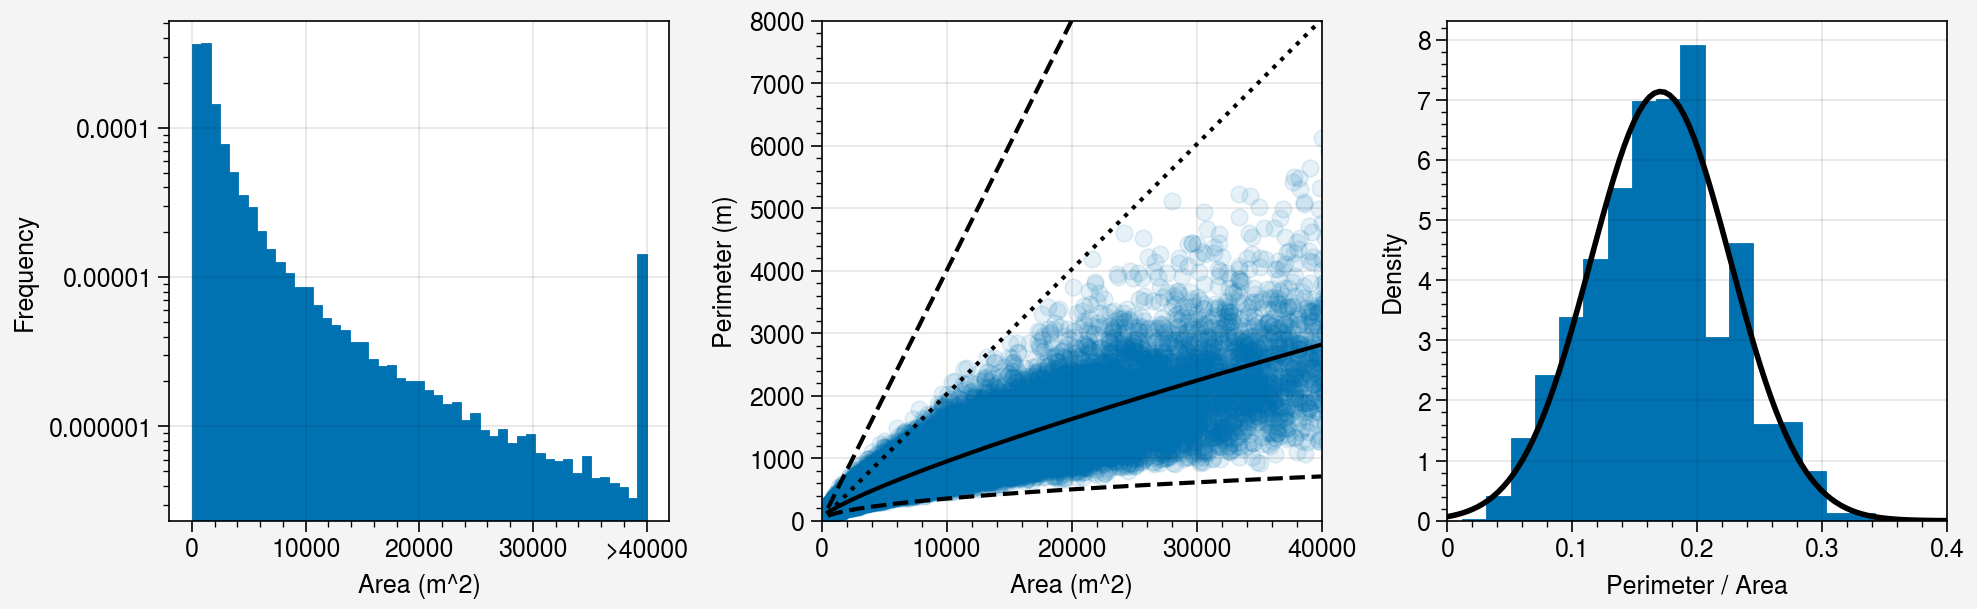

In [154]:
fig, axes = pplt.subplots(nrows=1, ncols=3, share=False)

bin_edges = np.linspace(0, max_size, 50)
axes[0].hist(np.clip(small_outbreaks['area'], bin_edges[0], bin_edges[-1]), bins=bin_edges, density=True)

# Code for adding exponential fit. Data is not exponential though, Dispaying more rapid initial declines and heavier tail
#P = expon.fit(small_outbreaks['area']) 
#xmin, xmax = 0, 40000
#x = np.linspace(xmin, xmax, 100)
#y = expon.pdf(x, *P)
#axes[0].plot(x, y, 'k', linewidth=2)

axes[0].format(xlabel='Area (m^2)', ylabel='Frequency', yscale='log', xticklabels=['0', '10000', '20000', '30000', '>40000'], xlocator=[0, 10000, 20000, 30000, 40000])

axes[1].scatter(small_outbreaks['area'], small_outbreaks['perimeter'], alpha=0.1)
axes[1].plot(circle_area, circle_perimeter, color='black', linestyle='dashed')
axes[1].plot(line_area, line_perimeter, color='black', linestyle='dotted')
axes[1].plot(diagonal_area, diagonal_perimeter, color='black', linestyle='dashed')
#axes[1].plot(pred_area, pred_perimeter_sqrt, color='black')
#axes[1].plot(pred_area, pred_perimeter_lin, color='black')
axes[1].plot(pred_area, pred_perimeter_free, color='black')
axes[1].format(xlim=[0, max_size], ylim=[0,line_perimeter.max()], xlabel='Area (m^2)', ylabel='Perimeter (m)')
#axes[1].hist2d(small_outbreaks['area'], small_outbreaks['perimeter'], bins=1000)

axes[2].hist(small_outbreaks['ratio'], bins=20, density=True)

mu, std = norm.fit(small_outbreaks['ratio']) 
xmin, xmax = 0, 0.4
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)

axes[2].plot(x, p, 'k', linewidth=2)

axes[2].format(xlabel='Perimeter / Area', ylabel='Density')


# In the future, consider if we want to do the inner/total edge ratio similar to McCabe and Dietze 2019
# I am not sure if that is the most usual metric of linear vs circular
"""
total = 4*small_outbreaks['count']
outer = small_outbreaks['sum']
inner = (total - outer) / 2

line_inner = length - 1
line_outer = 4*length

axes[2].scatter(small_outbreaks['area'], inner / total, alpha=0.1)
axes[2].plot(line_area, line_inner / line_total, color='black')
"""

fig.savefig('./Figures/medium_disturbance_size_shape_distribution.png')

In [144]:
popt_free

array([53.96102276,  0.497787  ,  0.81367445])

In [145]:
np.count_nonzero(outbreaks['area'] > 40000)

3031

In [146]:
np.count_nonzero(outbreaks['area'] <= 1000) / outbreaks['area'].count()

0.7857143838146892

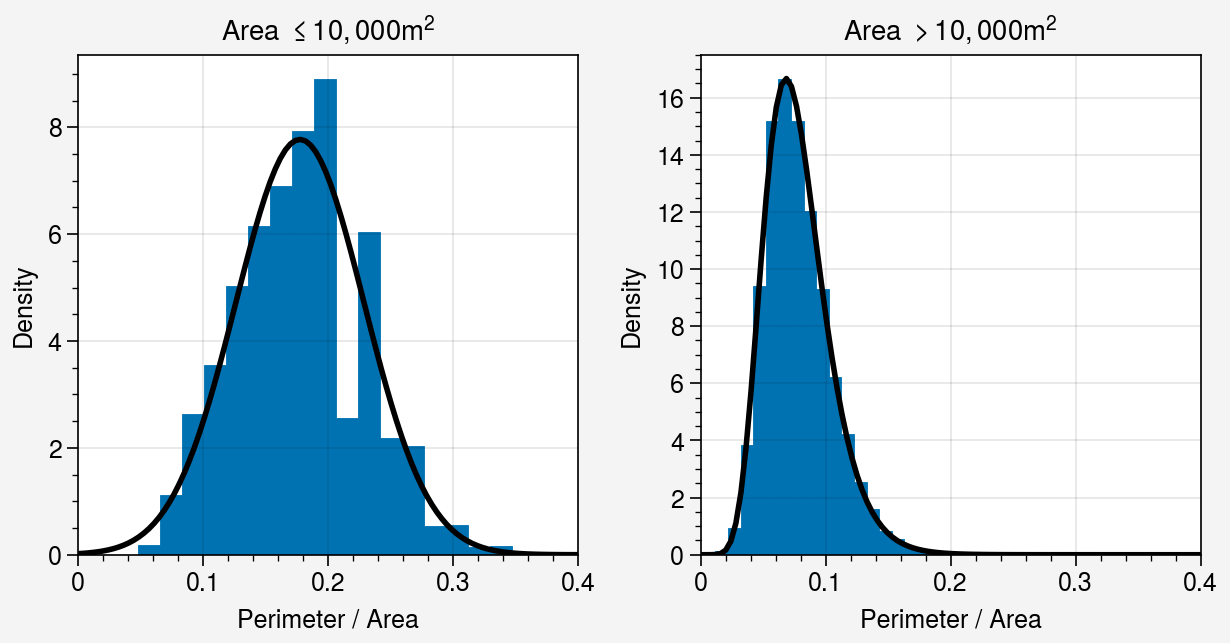

In [147]:
fig, axes = pplt.subplots(nrows=1, ncols=2, share=False)

cutoff = 10000
mask = small_outbreaks['area'] < cutoff


axes[0].hist(small_outbreaks.loc[mask, 'ratio'], bins=20, density=True)

mu, std = norm.fit(small_outbreaks.loc[mask, 'ratio']) 
xmin, xmax = 0, 0.4
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)

axes[0].plot(x, p, 'k', linewidth=2)

axes[0].format(xlabel='Perimeter / Area', ylabel='Density', title="Area $\leq 10,000m^2$")


axes[1].hist(small_outbreaks.loc[~mask, 'ratio'], bins=20, density=True)

s, loc, scale = lognorm.fit(small_outbreaks.loc[~mask, 'ratio']) 
xmin, xmax = 0, 0.4
x = np.linspace(xmin, xmax, 100)
p = lognorm.pdf(x, s, loc, scale)

axes[1].plot(x, p, 'k', linewidth=2)

axes[1].format(xlabel='Perimeter / Area', ylabel='Density', title="Area $> 10,000m^2$")


# In the future, consider if we want to do the inner/total edge ratio similar to McCabe and Dietze 2019
# I am not sure if that is the most usual metric of linear vs circular
"""
total = 4*small_outbreaks['count']
outer = small_outbreaks['sum']
inner = (total - outer) / 2

line_inner = length - 1
line_outer = 4*length

axes[2].scatter(small_outbreaks['area'], inner / total, alpha=0.1)
axes[2].plot(line_area, line_inner / line_total, color='black')
"""

fig.savefig('./Figures/shape_distribution_size dependence.png')

0.18238663420182935
0.17168204695088787
0.1682017475173172


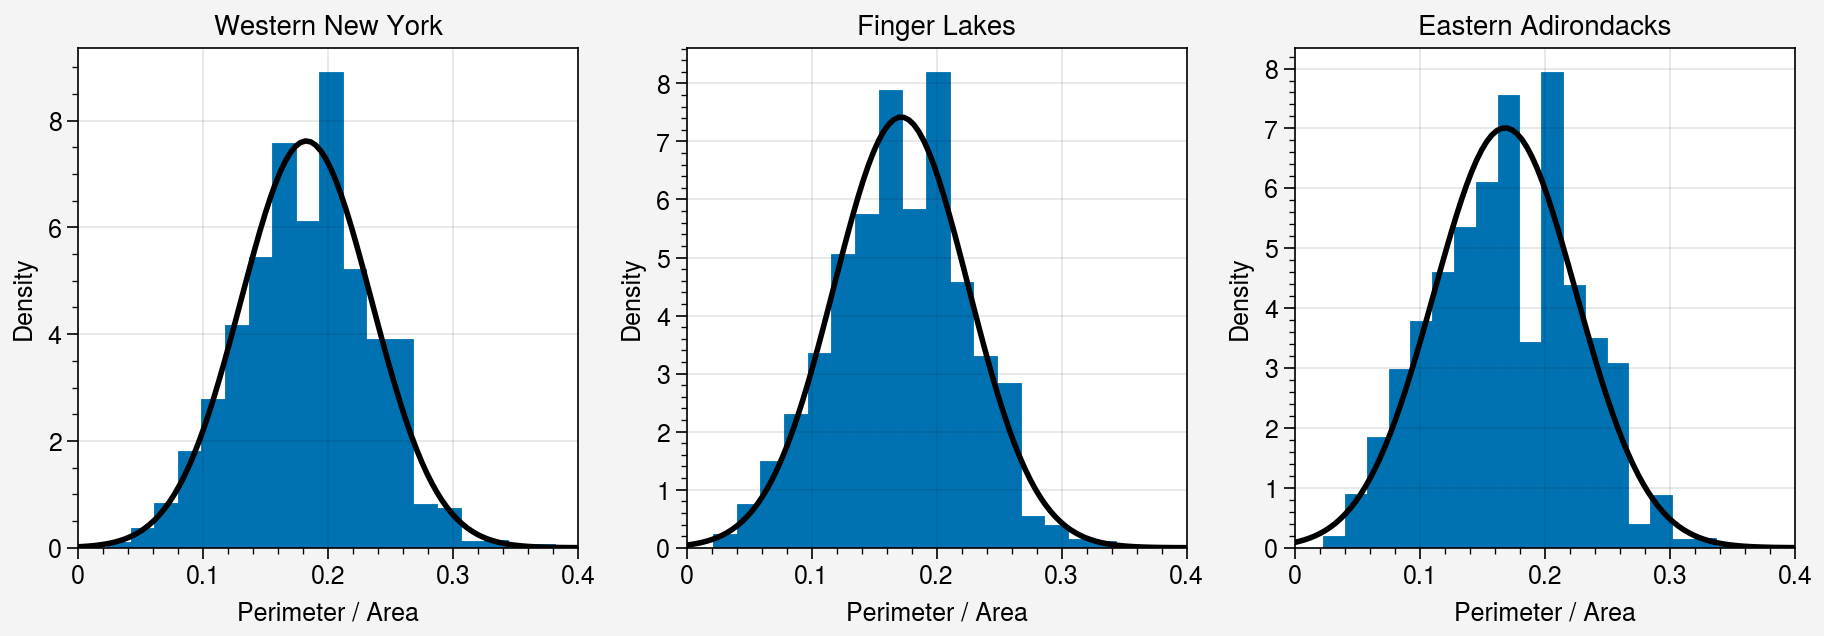

In [148]:
fig, axes = pplt.subplots(nrows=1, ncols=3, share=False)

western = county_2019['ADM2_NAME'].isin(['Cattaraugus', 'Allegheny'])

western_mask = small_outbreaks.within(county_2019[western].unary_union)

central = county_2019['ADM2_NAME'].isin(['Tompkins', 'Schuyler'])

central_mask = small_outbreaks.within(county_2019[central].unary_union)

eastern = county_2019['ADM2_NAME'].isin(['Warren', 'Washington'])

eastern_mask = small_outbreaks.within(county_2019[eastern].unary_union)


axes[0].hist(small_outbreaks.loc[western_mask, 'ratio'], bins=20, density=True)

mu, std = norm.fit(small_outbreaks.loc[western_mask, 'ratio']) 
print(mu)
xmin, xmax = 0, 0.4
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)

axes[0].plot(x, p, 'k', linewidth=2)

axes[0].format(xlabel='Perimeter / Area', ylabel='Density', title="Western New York")


axes[1].hist(small_outbreaks.loc[central_mask, 'ratio'], bins=20, density=True)

mu, std = norm.fit(small_outbreaks.loc[central_mask, 'ratio']) 
print(mu)
xmin, xmax = 0, 0.4
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)

axes[1].plot(x, p, 'k', linewidth=2)

axes[1].format(xlabel='Perimeter / Area', ylabel='Density', title="Finger Lakes")


axes[2].hist(small_outbreaks.loc[eastern_mask, 'ratio'], bins=20, density=True)

mu, std = norm.fit(small_outbreaks.loc[eastern_mask, 'ratio']) 
print(mu)
xmin, xmax = 0, 0.4
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)

axes[2].plot(x, p, 'k', linewidth=2)

axes[2].format(xlabel='Perimeter / Area', ylabel='Density', title="Eastern Adirondacks")


# In the future, consider if we want to do the inner/total edge ratio similar to McCabe and Dietze 2019
# I am not sure if that is the most usual metric of linear vs circular
"""
total = 4*small_outbreaks['count']
outer = small_outbreaks['sum']
inner = (total - outer) / 2

line_inner = length - 1
line_outer = 4*length

axes[2].scatter(small_outbreaks['area'], inner / total, alpha=0.1)
axes[2].plot(line_area, line_inner / line_total, color='black')
"""

fig.savefig('./Figures/shape_distribution_location_dependence.png')

In [149]:
outbreaks.loc[western_mask, "ratio"].mean()

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [ ]:
western_mask = outbreaks.within(county_2019[western].unary_union)

outbreaks.loc[western_mask, "area"].mean()

In [ ]:
central_mask = outbreaks.within(county_2019[central].unary_union)

outbreaks.loc[central_mask, "area"].mean()

In [ ]:
eastern_mask = outbreaks.within(county_2019[eastern].unary_union)

outbreaks.loc[eastern_mask, "area"].mean()

In [ ]:
outbreaks.loc[~(eastern_mask | central_mask | western_mask), "area"].mean()

In [ ]:
outbreaks['area'].mean()

In [ ]:
np.count_nonzero(outbreaks["area"] < 3000) / outbreaks['area'].count()

#  Figure 7 - Landcover breakdown

## Load Data

In [128]:
landcover_counts = pd.read_csv('./Data/landcover_counts.csv')

In [129]:
landcover_counts['rate'] = landcover_counts['intense'] / landcover_counts['total']

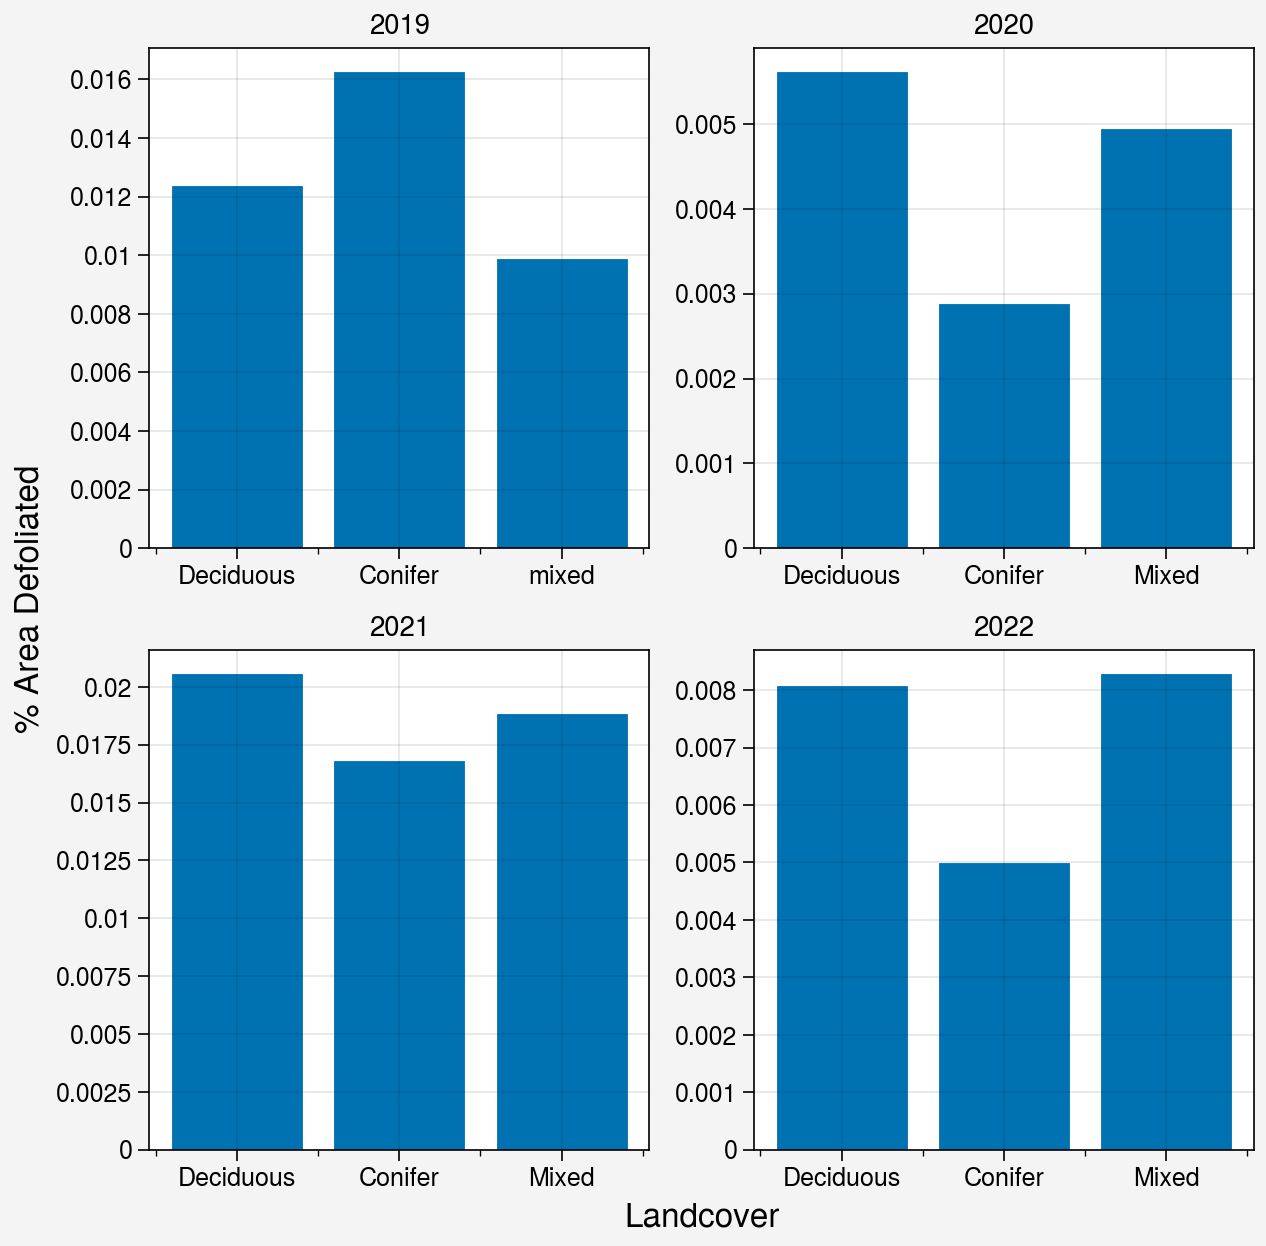

In [130]:
fig, axes = pplt.subplots(nrows=2, ncols=2, share=1)

counts_2019 = landcover_counts[landcover_counts['year'] == 2019.0]
axes[0].bar(counts_2019['landcover'], counts_2019['rate'])
axes[0].format(xlocator=[0, 1, 2], xminorlocator=0.5, ytickminor=False, xticklabels=['Deciduous', 'Conifer', 'mixed'], ylabel='% Area Defoliated', xlabel='Landcover', labelsize=12, title='2019')

counts_2020 = landcover_counts[landcover_counts['year'] == 2020.0]
axes[1].bar(counts_2020['landcover'], counts_2020['rate'])
axes[1].format(xlocator=[0, 1, 2], xminorlocator=0.5, ytickminor=False, xticklabels=['Deciduous', 'Conifer', 'Mixed'], ylabel='% Area Defoliated', xlabel='Landcover', labelsize=12, title='2020')

counts_2021 = landcover_counts[landcover_counts['year'] == 2021.0]
axes[2].bar(counts_2021['landcover'], counts_2021['rate'])
axes[2].format(xlocator=[0, 1, 2], xminorlocator=0.5, ytickminor=False, xticklabels=['Deciduous', 'Conifer', 'Mixed'], ylabel='% Area Defoliated', xlabel='Landcover', labelsize=12, title='2021')

counts_2022 = landcover_counts[landcover_counts['year'] == 2022.0]
axes[3].bar(counts_2022['landcover'], counts_2022['rate'])
axes[3].format(xlocator=[0, 1, 2], xminorlocator=0.5, ytickminor=False, xticklabels=['Deciduous', 'Conifer', 'Mixed'], ylabel='% Area Defoliated', xlabel='Landcover', labelsize=12, title='2022')

fig.savefig('./Figures/landcover_defoliation_rate.png')

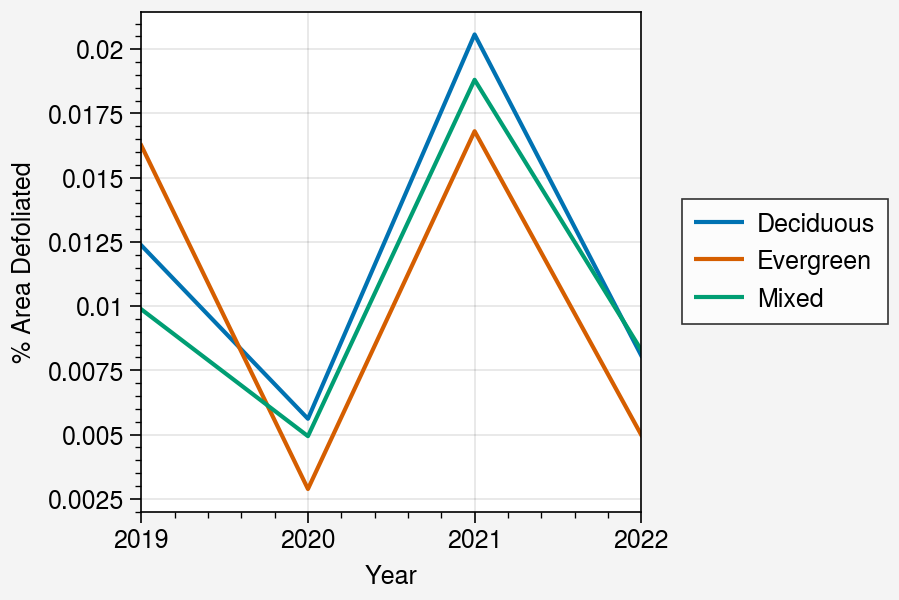

In [137]:
fig, ax = pplt.subplots(nrows=1, ncols=1, share=1)

count_deciduous = landcover_counts[landcover_counts['landcover'] == 'deciduous']
count_evergreen = landcover_counts[landcover_counts['landcover'] == 'evergreen']
count_mixed = landcover_counts[landcover_counts['landcover'] == 'mixed']

ax.plot([2019, 2020, 2021, 2022], count_deciduous['rate'], label='Deciduous')
ax.plot([2019, 2020, 2021, 2022], count_evergreen['rate'], label='Evergreen')
ax.plot([2019, 2020, 2021, 2022], count_mixed['rate'], label='Mixed')

ax.legend(ncols=1, loc='r')
ax.format(xlabel='Year', ylabel='% Area Defoliated', xlocator=[2019, 2020, 2021, 2022])

fig.savefig('./Figures/landcover_defoliation_rate_linegraph.png')

# Figure 8 - Landcover breakdown of Intra-annual patterns

## Load Data

In [125]:
landcover_counts = pd.read_csv('./Data/landcover_counts.csv')

In [126]:
landcover_counts['rate'] = landcover_counts['intense'] / landcover_counts['total']

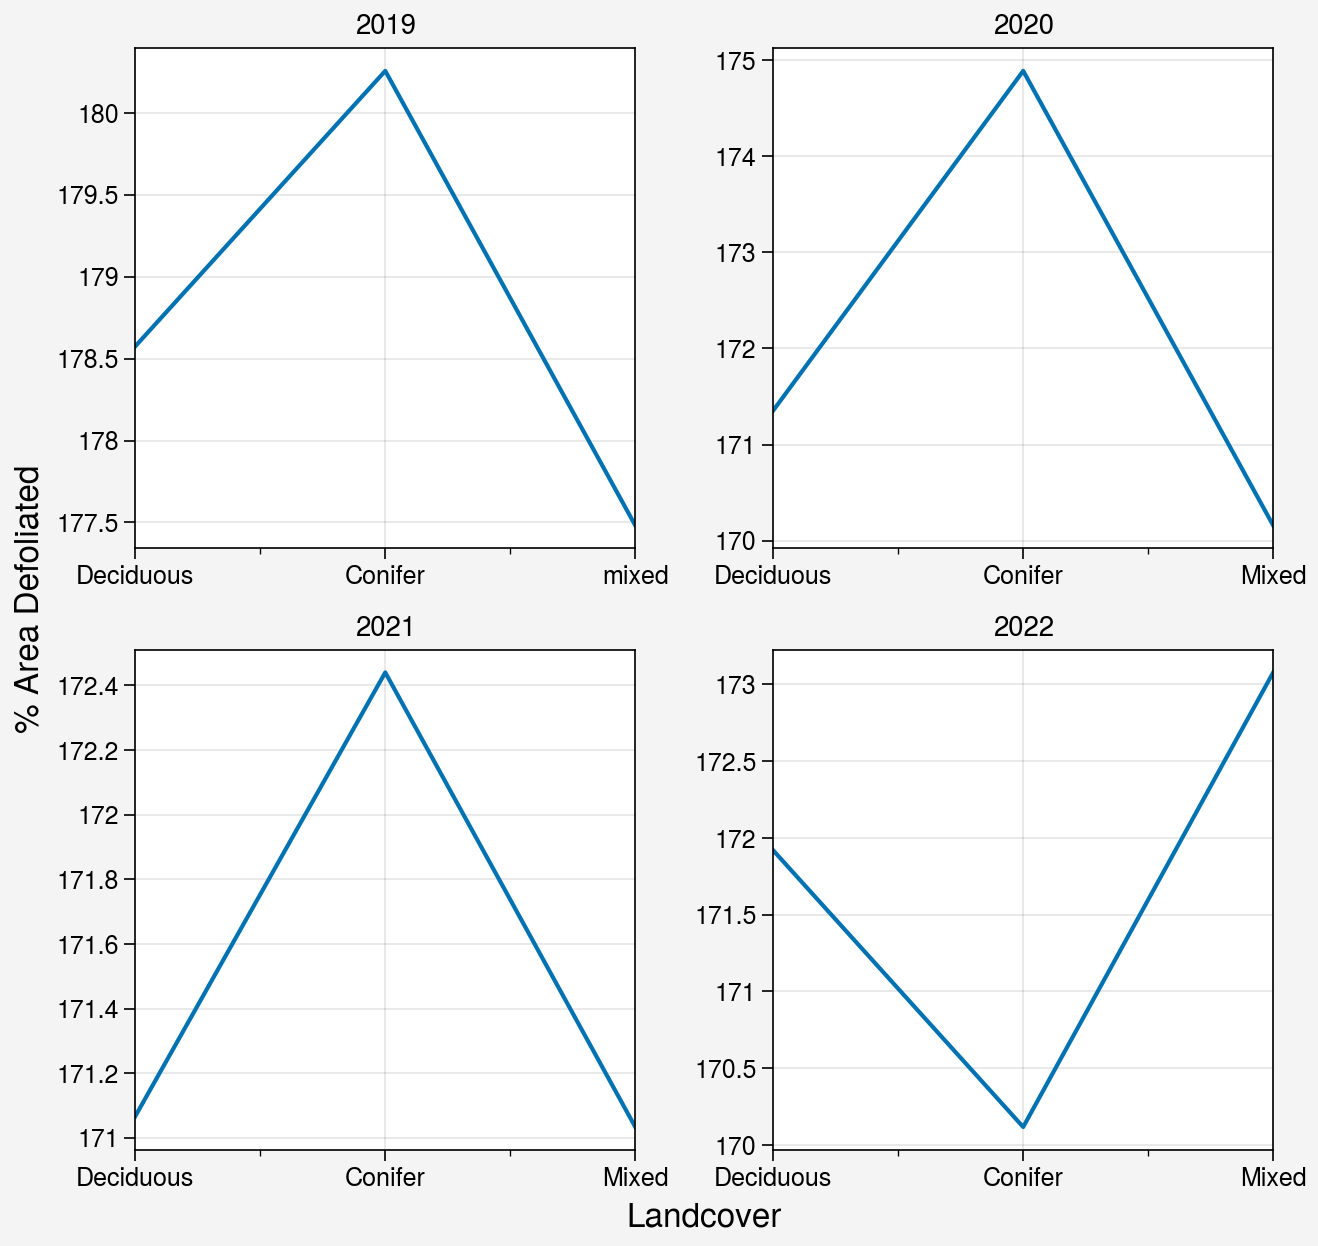

In [127]:
fig, axes = pplt.subplots(nrows=2, ncols=2, share=1)

counts_2019 = landcover_counts[landcover_counts['year'] == 2019.0]
axes[0].plot(counts_2019['landcover'], counts_2019['mean_start'])
axes[0].format(xlocator=[0, 1, 2], xminorlocator=0.5, ytickminor=False, xticklabels=['Deciduous', 'Conifer', 'mixed'], ylabel='% Area Defoliated', xlabel='Landcover', labelsize=12, title='2019')

counts_2020 = landcover_counts[landcover_counts['year'] == 2020.0]
axes[1].plot(counts_2020['landcover'], counts_2020['mean_start'])
axes[1].format(xlocator=[0, 1, 2], xminorlocator=0.5, ytickminor=False, xticklabels=['Deciduous', 'Conifer', 'Mixed'], ylabel='% Area Defoliated', xlabel='Landcover', labelsize=12, title='2020')

counts_2021 = landcover_counts[landcover_counts['year'] == 2021.0]
axes[2].plot(counts_2021['landcover'], counts_2021['mean_start'])
axes[2].format(xlocator=[0, 1, 2], xminorlocator=0.5, ytickminor=False, xticklabels=['Deciduous', 'Conifer', 'Mixed'], ylabel='% Area Defoliated', xlabel='Landcover', labelsize=12, title='2021')

counts_2022 = landcover_counts[landcover_counts['year'] == 2022.0]
axes[3].plot(counts_2022['landcover'], counts_2022['mean_start'])
axes[3].format(xlocator=[0, 1, 2], xminorlocator=0.5, ytickminor=False, xticklabels=['Deciduous', 'Conifer', 'Mixed'], ylabel='% Area Defoliated', xlabel='Landcover', labelsize=12, title='2022')

fig.savefig('./Figures/landcover_defoliation_rate.png')

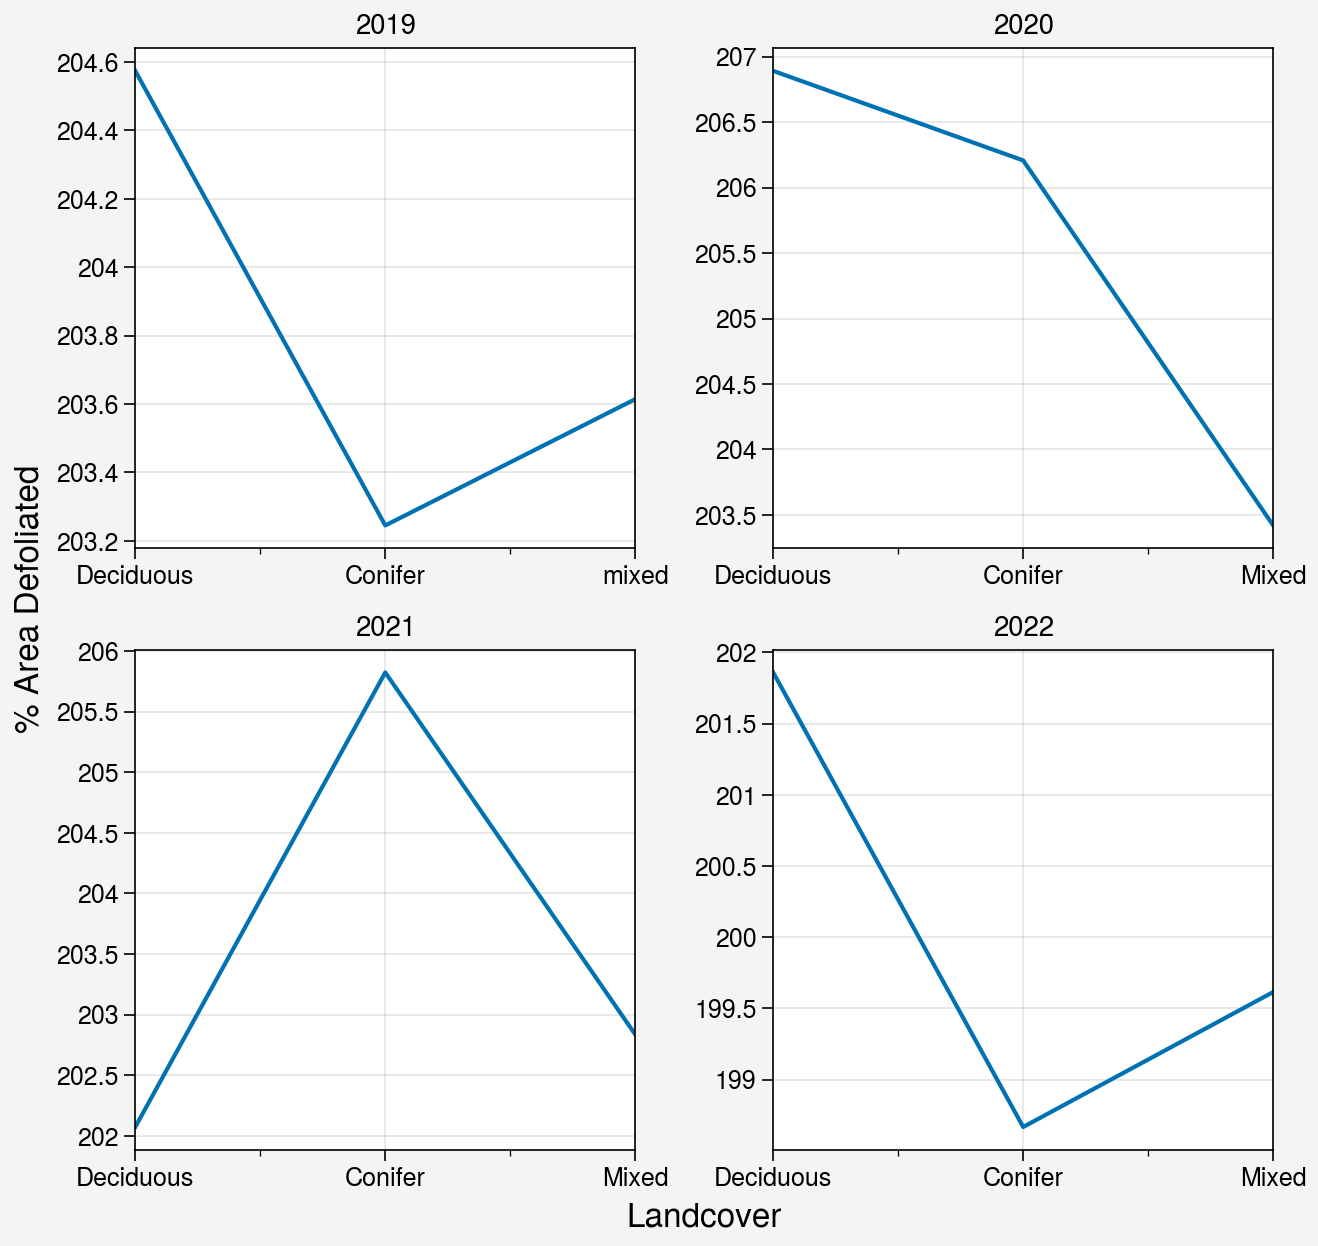

In [121]:
fig, axes = pplt.subplots(nrows=2, ncols=2, share=1)

counts_2019 = landcover_counts[landcover_counts['year'] == 2019.0]
axes[0].plot(counts_2019['landcover'], counts_2019['mean_peak'])
axes[0].format(xlocator=[0, 1, 2], xminorlocator=0.5, ytickminor=False, xticklabels=['Deciduous', 'Conifer', 'mixed'], ylabel='% Area Defoliated', xlabel='Landcover', labelsize=12, title='2019')

counts_2020 = landcover_counts[landcover_counts['year'] == 2020.0]
axes[1].plot(counts_2020['landcover'], counts_2020['mean_peak'])
axes[1].format(xlocator=[0, 1, 2], xminorlocator=0.5, ytickminor=False, xticklabels=['Deciduous', 'Conifer', 'Mixed'], ylabel='% Area Defoliated', xlabel='Landcover', labelsize=12, title='2020')

counts_2021 = landcover_counts[landcover_counts['year'] == 2021.0]
axes[2].plot(counts_2021['landcover'], counts_2021['mean_peak'])
axes[2].format(xlocator=[0, 1, 2], xminorlocator=0.5, ytickminor=False, xticklabels=['Deciduous', 'Conifer', 'Mixed'], ylabel='% Area Defoliated', xlabel='Landcover', labelsize=12, title='2021')

counts_2022 = landcover_counts[landcover_counts['year'] == 2022.0]
axes[3].plot(counts_2022['landcover'], counts_2022['mean_peak'])
axes[3].format(xlocator=[0, 1, 2], xminorlocator=0.5, ytickminor=False, xticklabels=['Deciduous', 'Conifer', 'Mixed'], ylabel='% Area Defoliated', xlabel='Landcover', labelsize=12, title='2022')

fig.savefig('./Figures/landcover_defoliation_rate.png')

In [124]:
landcover_counts

landcover      total  intense  year  mean_start    mean_end   mean_peak  \
0   deciduous  443099959  5479102  2019  178.575248  215.918687  204.574096   
1   deciduous  444198483  2493670  2020  171.354828  231.680093  206.891137   
2   deciduous  437475371  9000660  2021  171.066597  217.459346  202.073350   
3   deciduous  443538835  3581262  2022  171.918192  217.895895  201.859255   
4   evergreen   98498296  1600903  2019  180.255979  211.945574  203.245192   
5   evergreen   99120442   285523  2020  174.887165  225.825201  206.207398   
6   evergreen   97636516  1640981  2021  172.440191  218.770743  205.823328   
7   evergreen   99069625   493834  2022  170.117434  214.165859  198.667850   
8       mixed  134411927  1327380  2019  177.482015  215.585758  203.614410   
9       mixed  134671752   664871  2020  170.159459  228.764578  203.419845   
10      mixed  133244548  2506173  2021  171.033350  219.143227  202.835807   
11      mixed  134386286  1113705  2022  173.076523  214.756695  199.615368   

        rate  
0   0.012365  
1   0.005614  
2   0.020574  
3   0.008074  
4   0.016253  
5   0.002881  
6   0.016807  
7   0.004985  
8   0.009875  
9   0.004937  
10  0.018809  
11  0.008287

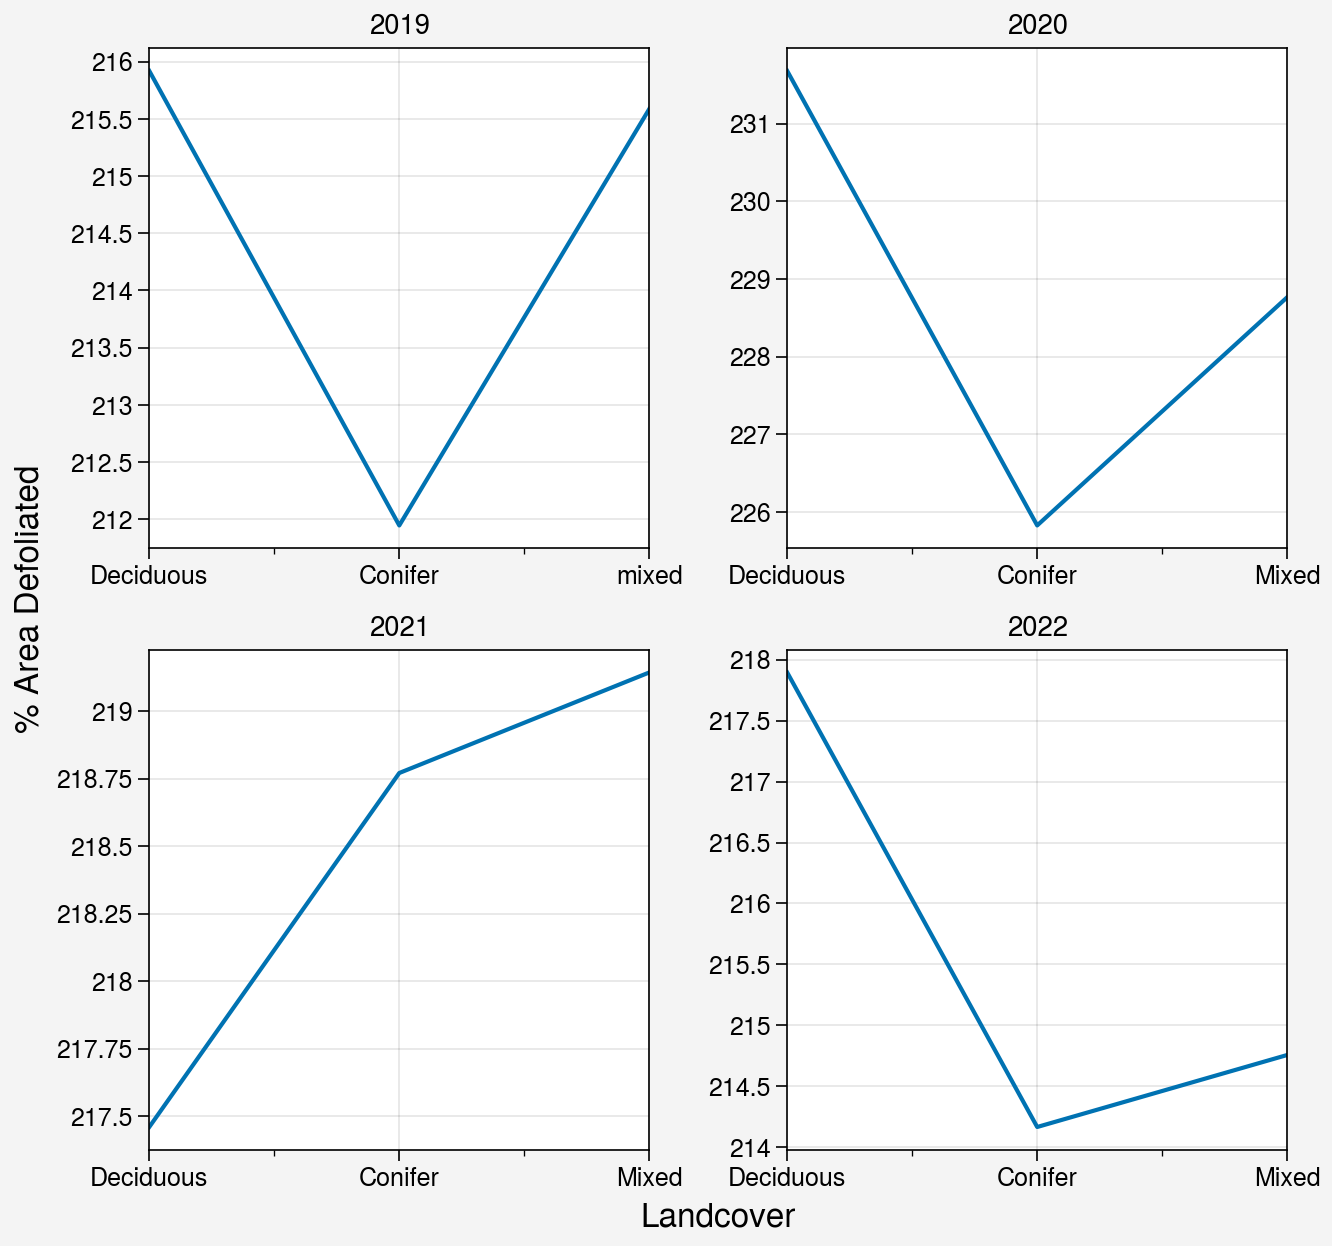

In [122]:
fig, axes = pplt.subplots(nrows=2, ncols=2, share=1)

counts_2019 = landcover_counts[landcover_counts['year'] == 2019.0]
axes[0].plot(counts_2019['landcover'], counts_2019['mean_end'])
axes[0].format(xlocator=[0, 1, 2], xminorlocator=0.5, ytickminor=False, xticklabels=['Deciduous', 'Conifer', 'mixed'], ylabel='% Area Defoliated', xlabel='Landcover', labelsize=12, title='2019')

counts_2020 = landcover_counts[landcover_counts['year'] == 2020.0]
axes[1].plot(counts_2020['landcover'], counts_2020['mean_end'])
axes[1].format(xlocator=[0, 1, 2], xminorlocator=0.5, ytickminor=False, xticklabels=['Deciduous', 'Conifer', 'Mixed'], ylabel='% Area Defoliated', xlabel='Landcover', labelsize=12, title='2020')

counts_2021 = landcover_counts[landcover_counts['year'] == 2021.0]
axes[2].plot(counts_2021['landcover'], counts_2021['mean_end'])
axes[2].format(xlocator=[0, 1, 2], xminorlocator=0.5, ytickminor=False, xticklabels=['Deciduous', 'Conifer', 'Mixed'], ylabel='% Area Defoliated', xlabel='Landcover', labelsize=12, title='2021')

counts_2022 = landcover_counts[landcover_counts['year'] == 2022.0]
axes[3].plot(counts_2022['landcover'], counts_2022['mean_end'])
axes[3].format(xlocator=[0, 1, 2], xminorlocator=0.5, ytickminor=False, xticklabels=['Deciduous', 'Conifer', 'Mixed'], ylabel='% Area Defoliated', xlabel='Landcover', labelsize=12, title='2022')

fig.savefig('./Figures/landcover_defoliation_rate.png')

# Figure 9 - Landcover breakdown of Spatial patterns

# Figure 10 - State-level impacts map